# Lesson 2: RAG Triad of metrics

In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
import utils

import os
import openai
openai.api_key = utils.get_openai_api_key()

In [34]:
from trulens_eval import Tru

tru = Tru()
tru.reset_database()

In [35]:
from llama_index import SimpleDirectoryReader

documents = SimpleDirectoryReader(
    input_files=["./eBook-How-to-Build-a-Career-in-AI.pdf"]
).load_data()

In [36]:
from llama_index import Document

document = Document(text="\n\n".\
                    join([doc.text for doc in documents]))

In [37]:
from utils import build_sentence_window_index

from llama_index.llms import OpenAI

llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1)

sentence_index = build_sentence_window_index(
    document,
    llm,
    embed_model="local:BAAI/bge-small-en-v1.5",
    save_dir="sentence_index"
)

In [38]:
from utils import get_sentence_window_query_engine

sentence_window_engine = \
get_sentence_window_query_engine(sentence_index)

In [39]:
output = sentence_window_engine.query(
    "How do you create your AI portfolio?")
output.response

'To create your AI portfolio, you should focus on building a collection of projects that demonstrate your skill progression. This can be achieved by starting with simpler projects and gradually working your way up to more complex ones. By showcasing a variety of projects, you can highlight your expertise in different areas of AI. Additionally, it is important to ensure that your portfolio reflects the specific skills and technologies that are relevant to the AI industry. This will help you stand out to potential employers and demonstrate your ability to work on real-world AI projects.'

## Feedback functions

In [40]:
import nest_asyncio

## Launch Streamlist dashboard

nest_asyncio.apply()

In [41]:
from trulens_eval import OpenAI as fOpenAI

provider = fOpenAI() ## To Implement different feedback functions such as Context,Answer and Grounded relevance

### 1. Answer Relevance

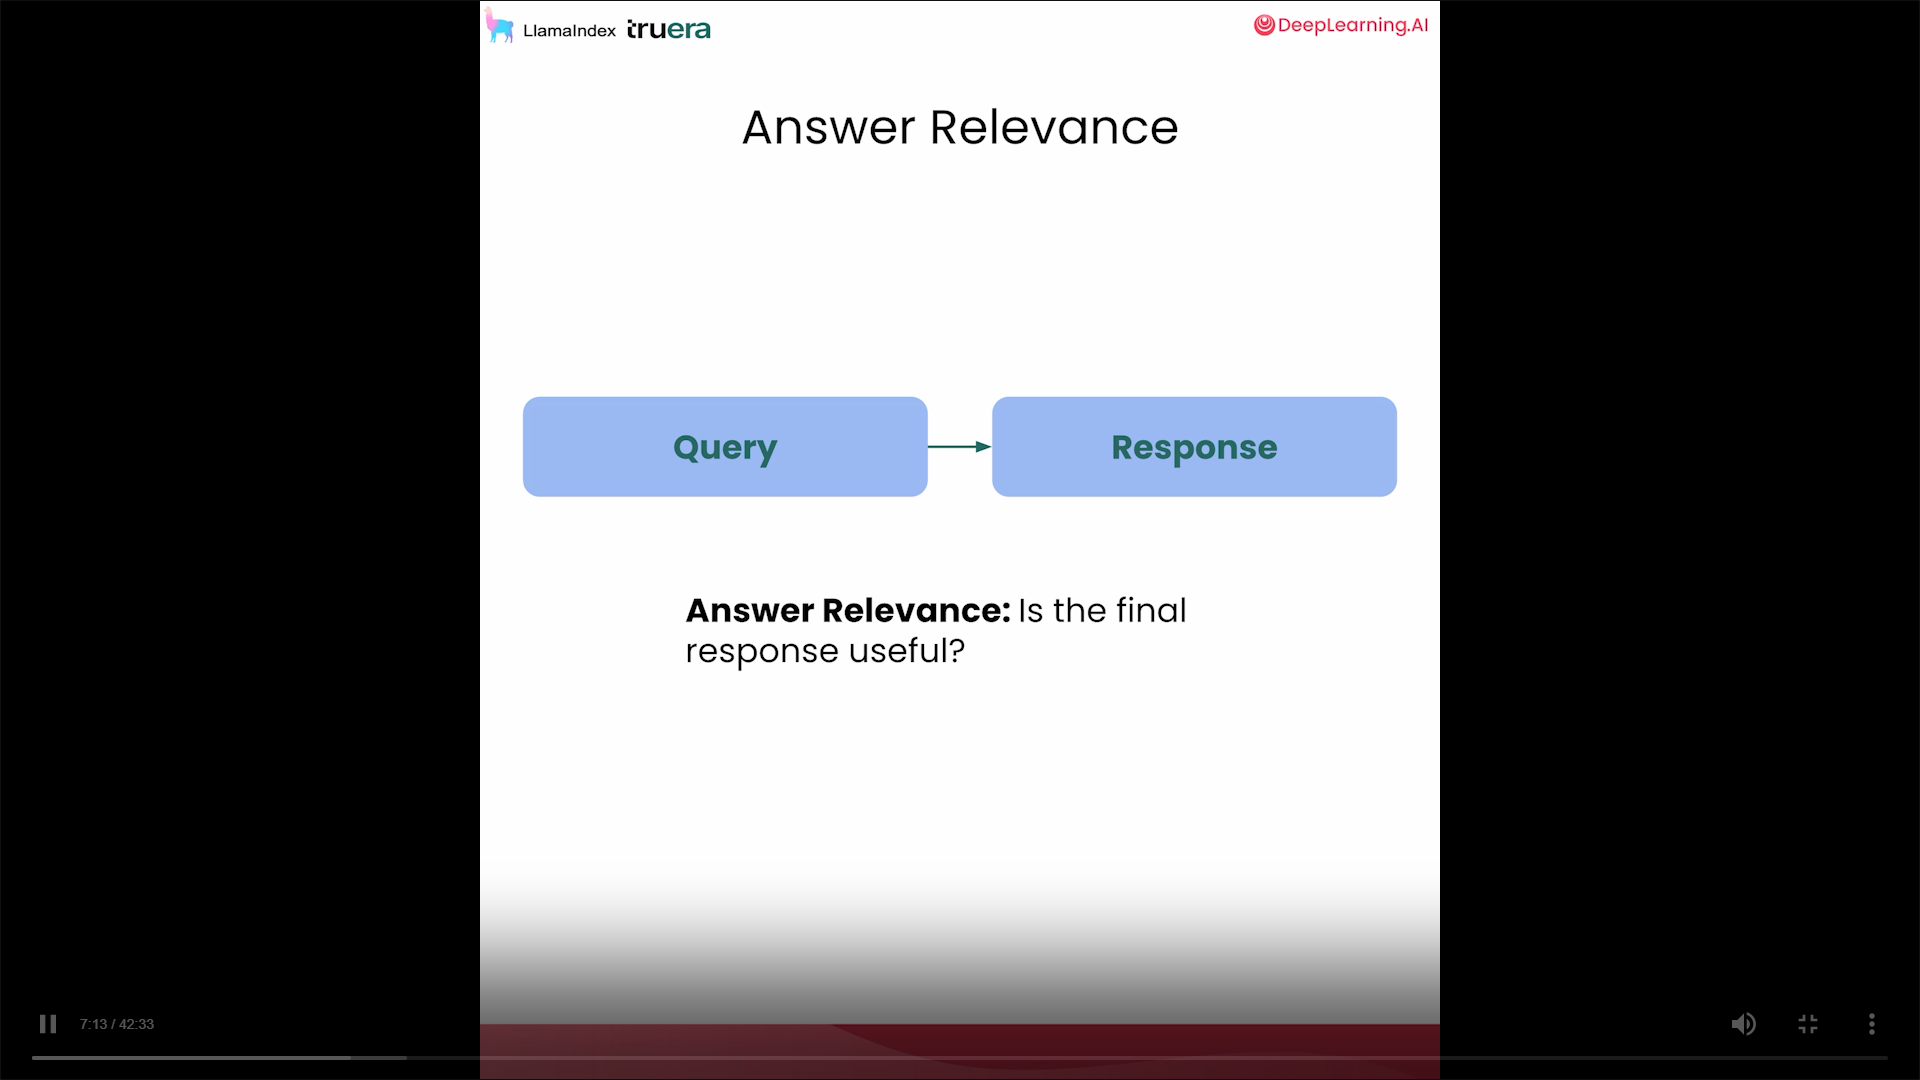

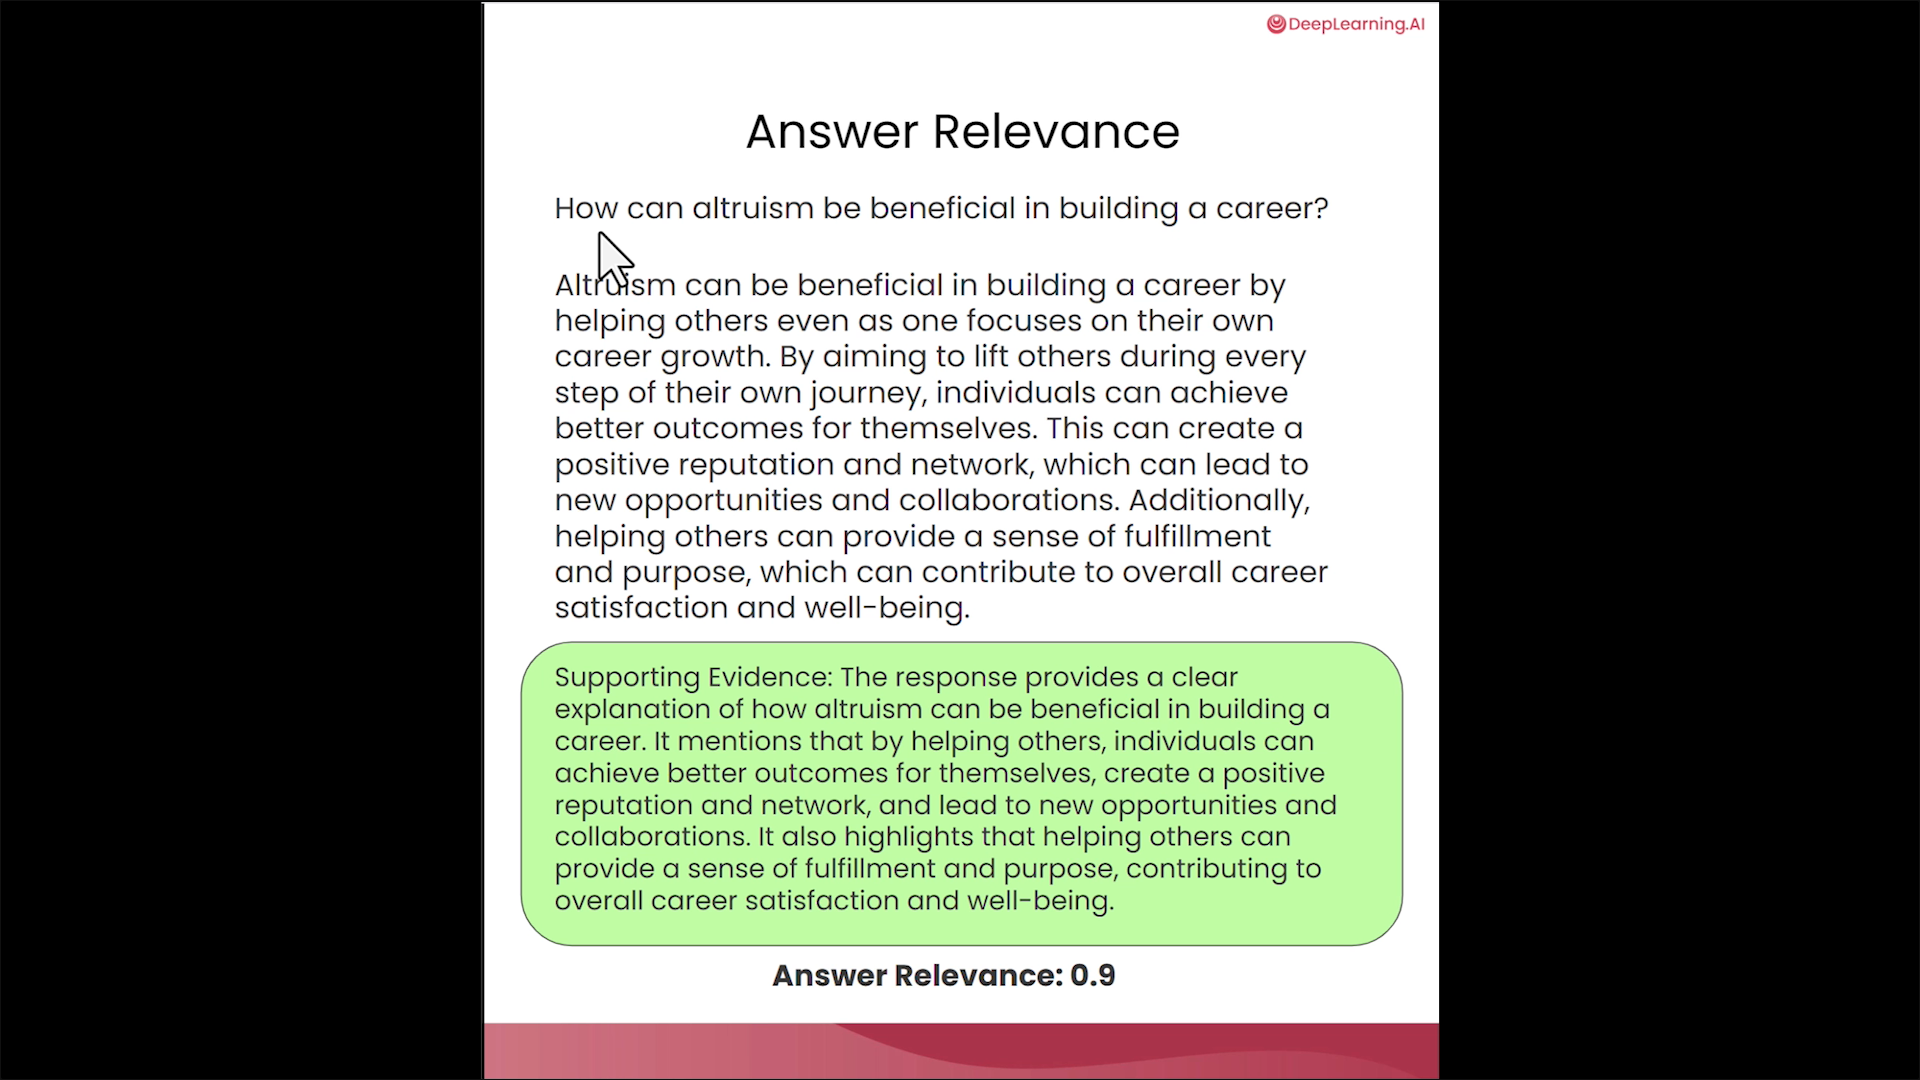

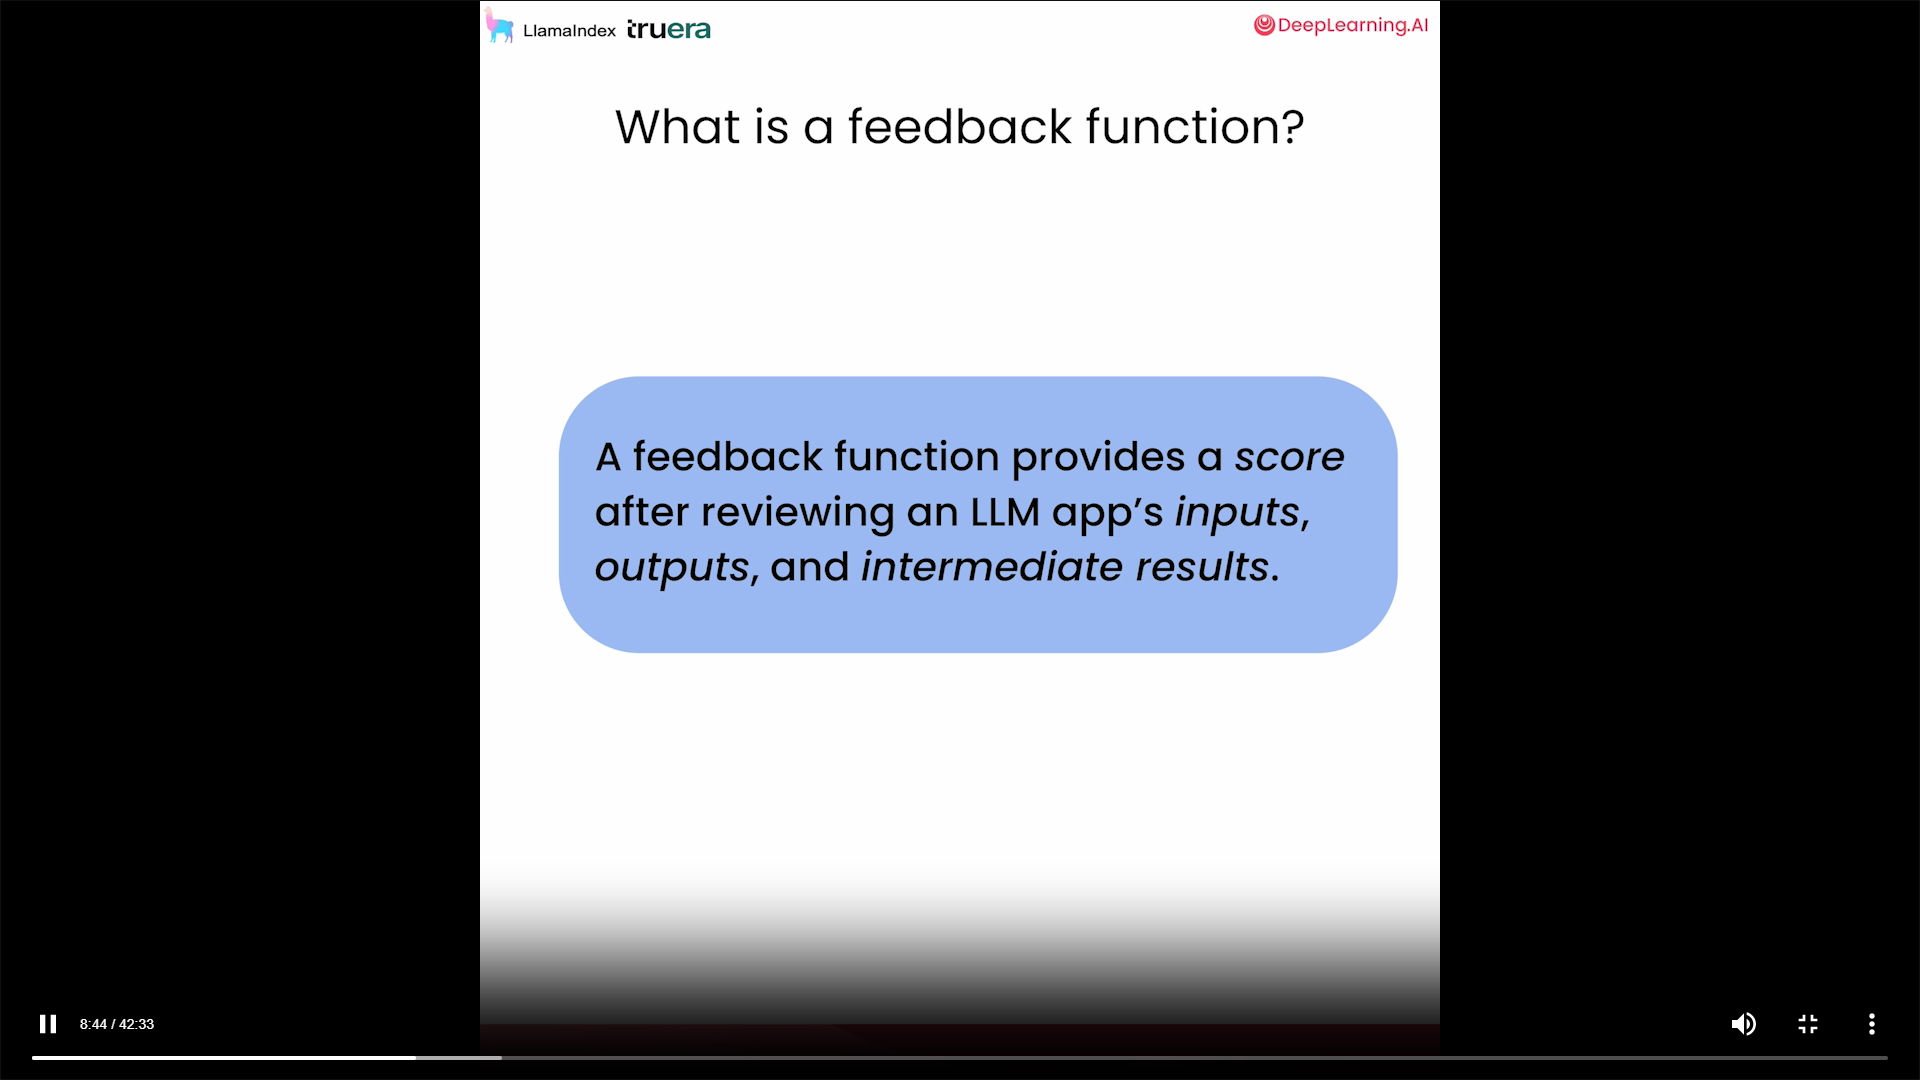

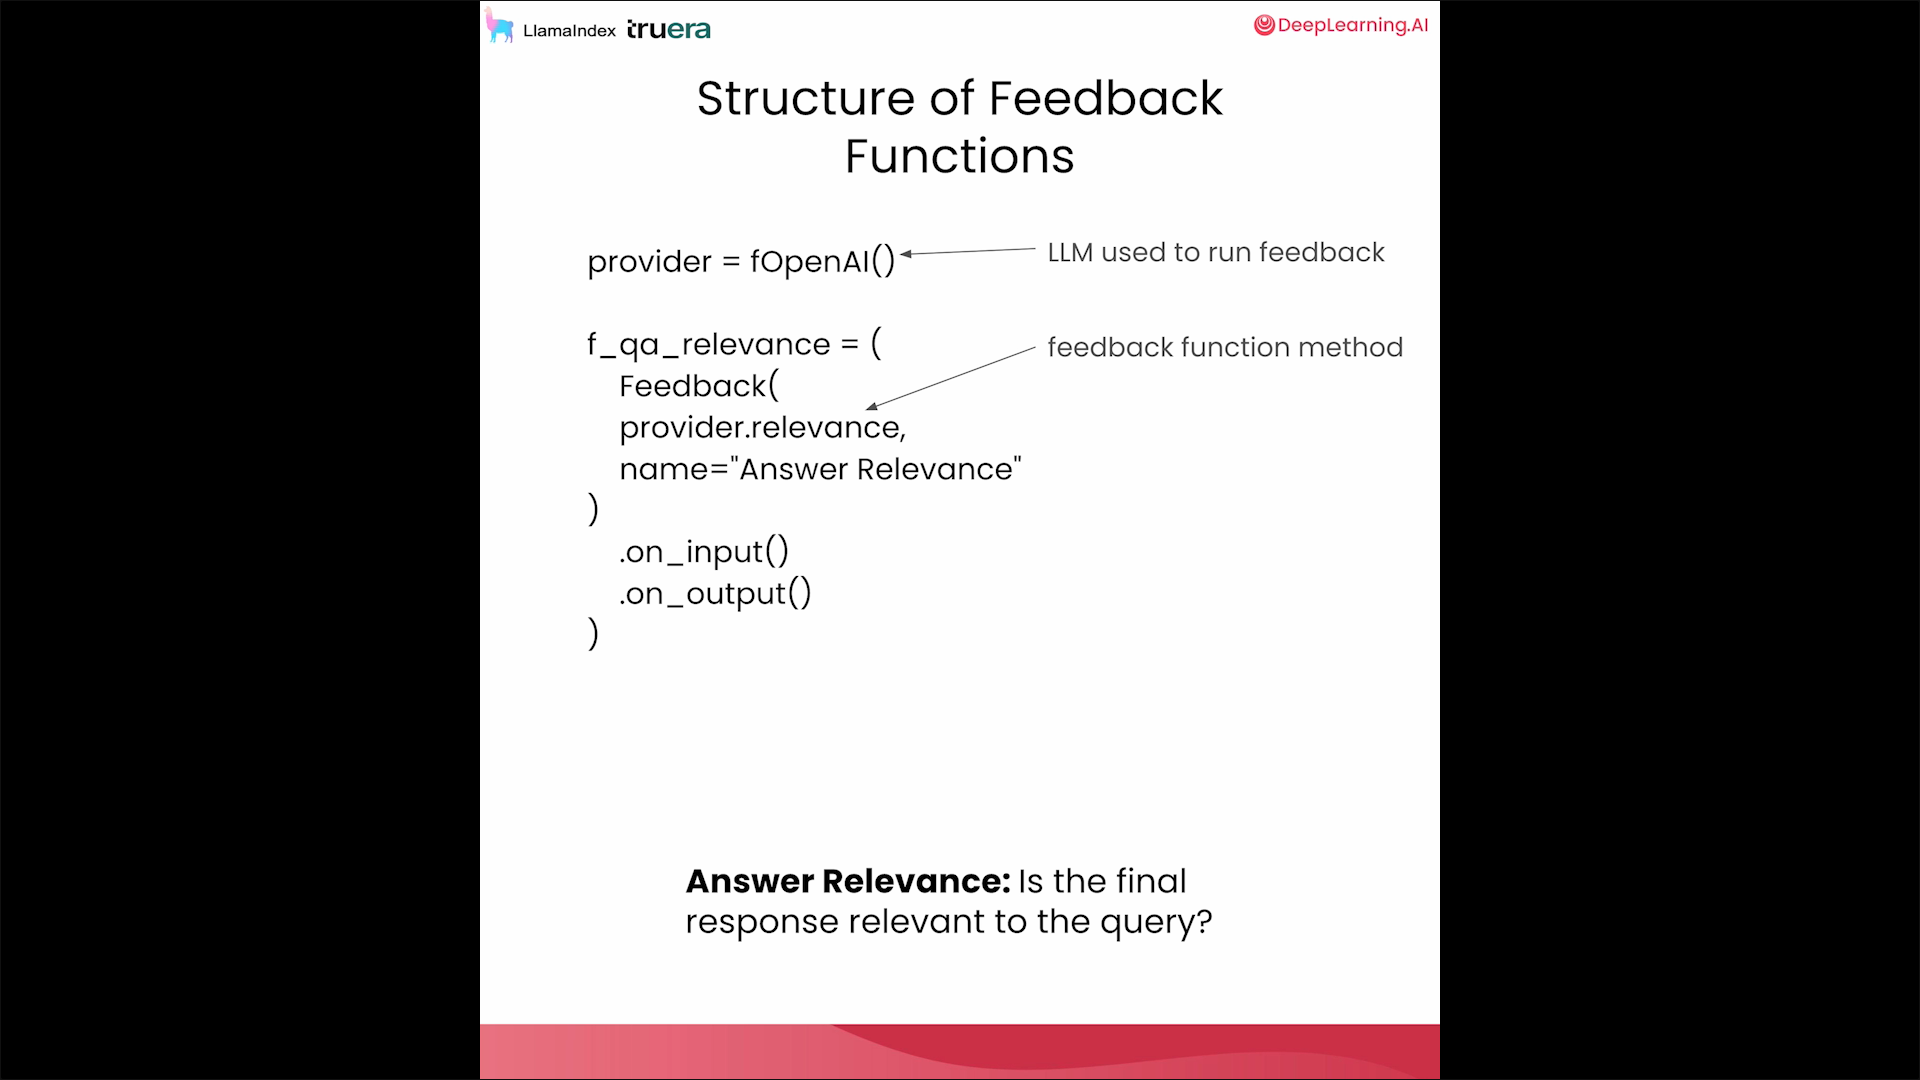

In [42]:
## Question Answer Relevance feedback function
from trulens_eval import Feedback

f_qa_relevance = Feedback(
    provider.relevance_with_cot_reasons,
    name="Answer Relevance"
).on_input_output()

✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .


Later on we will use this feedback function to get the Answer relevance score of example questions

### 2. Context Relevance

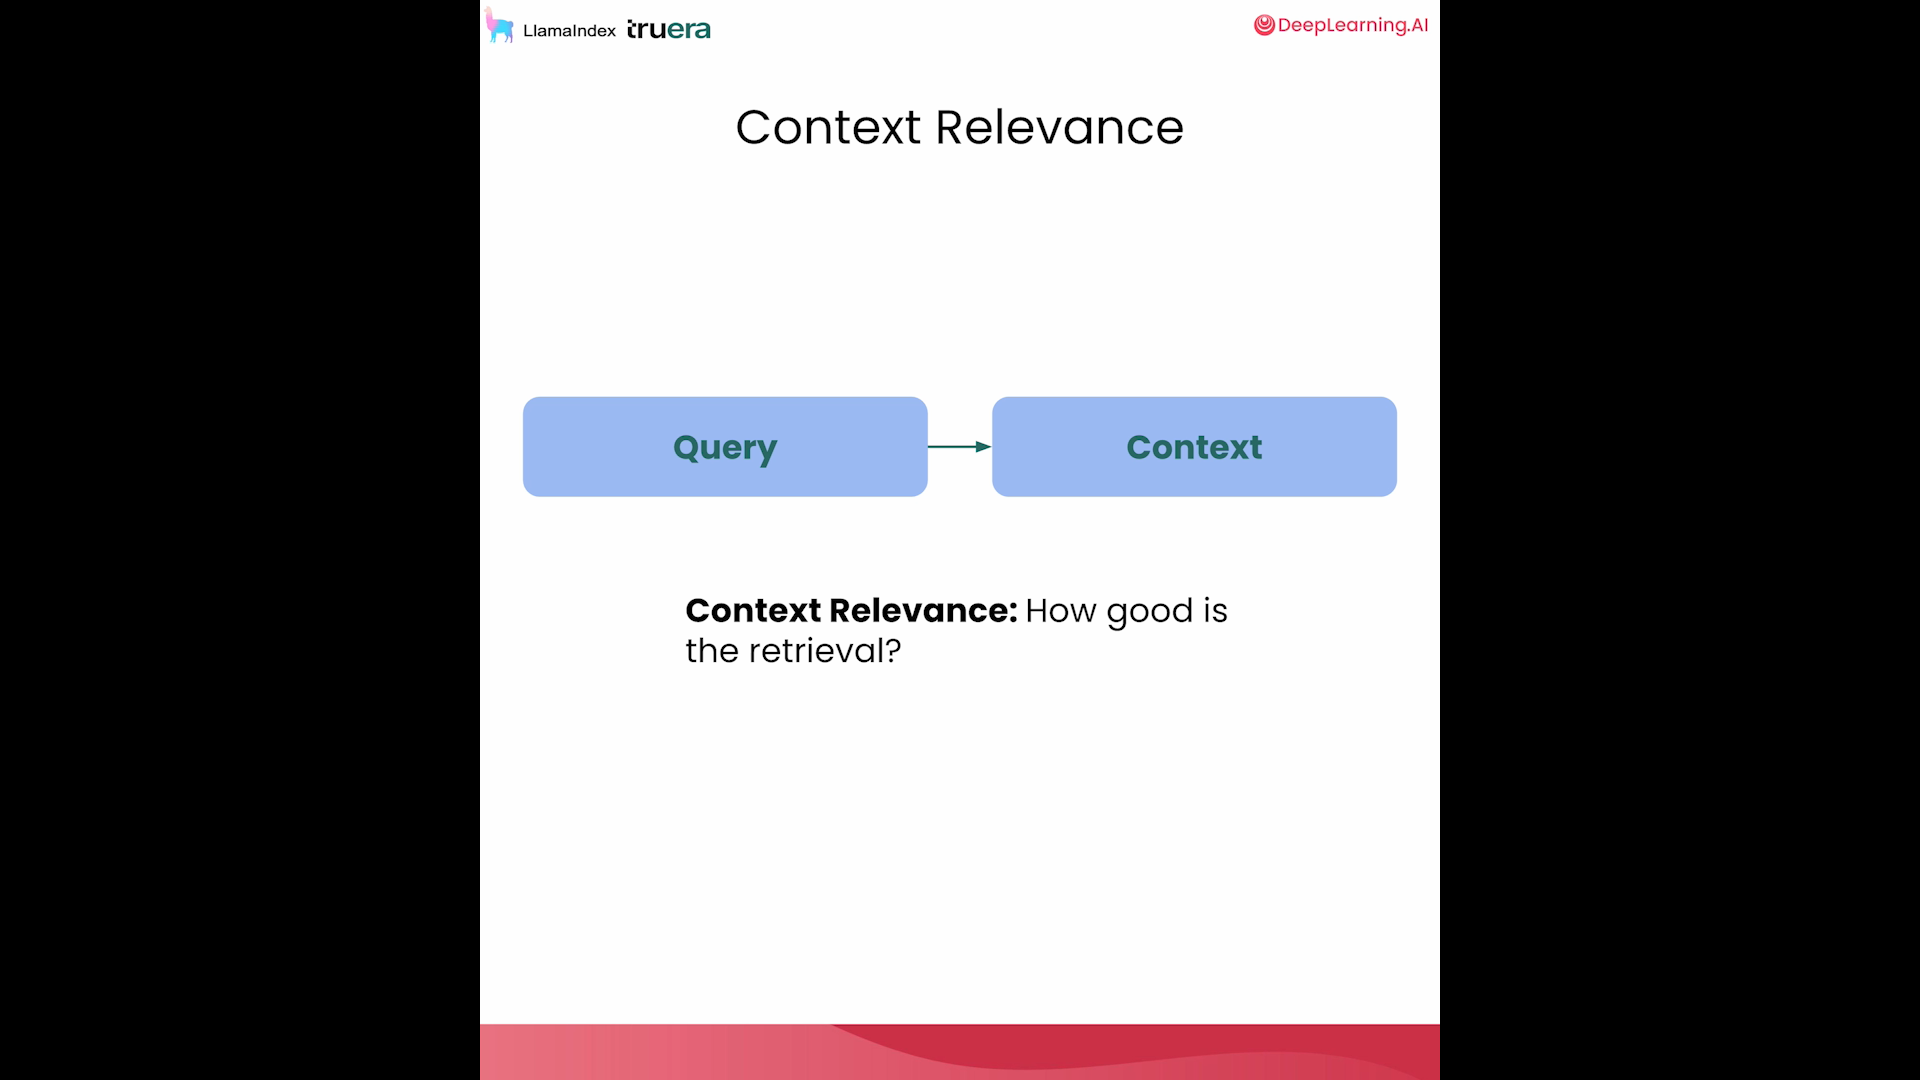

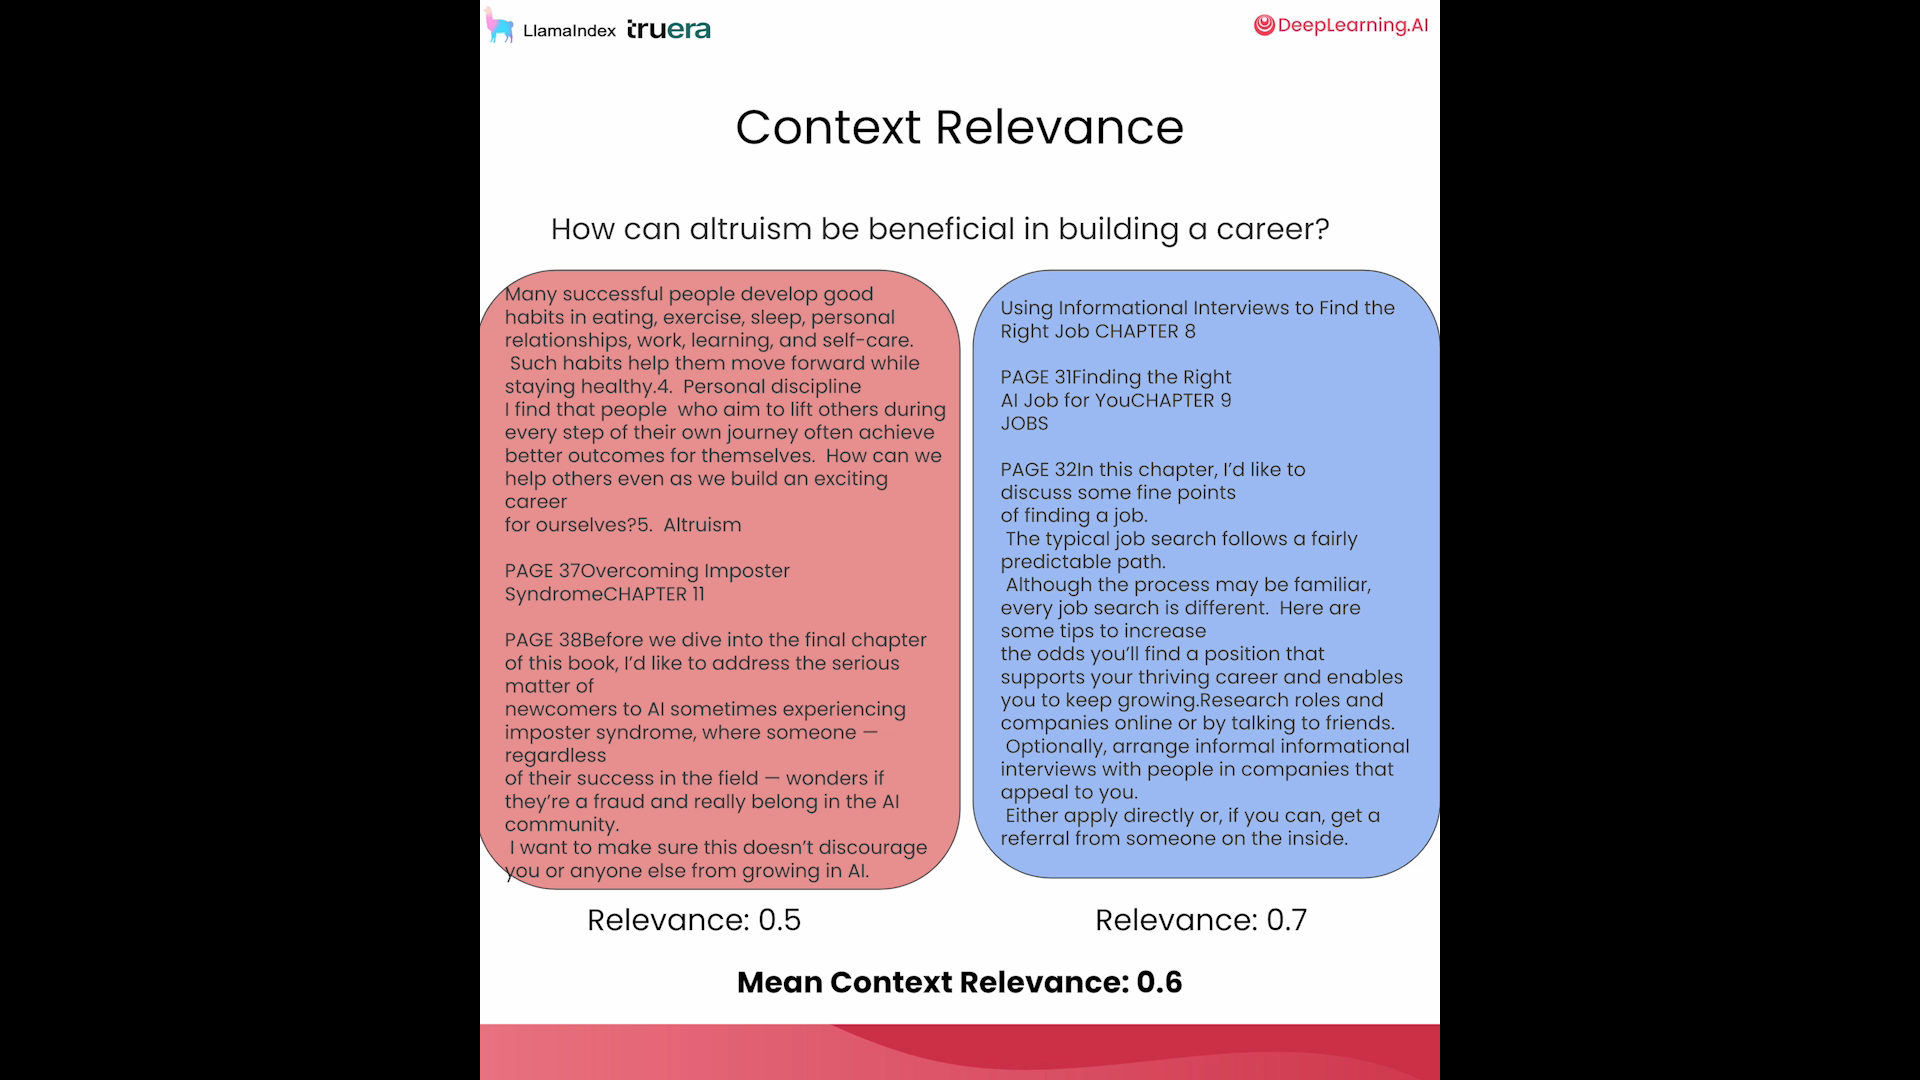

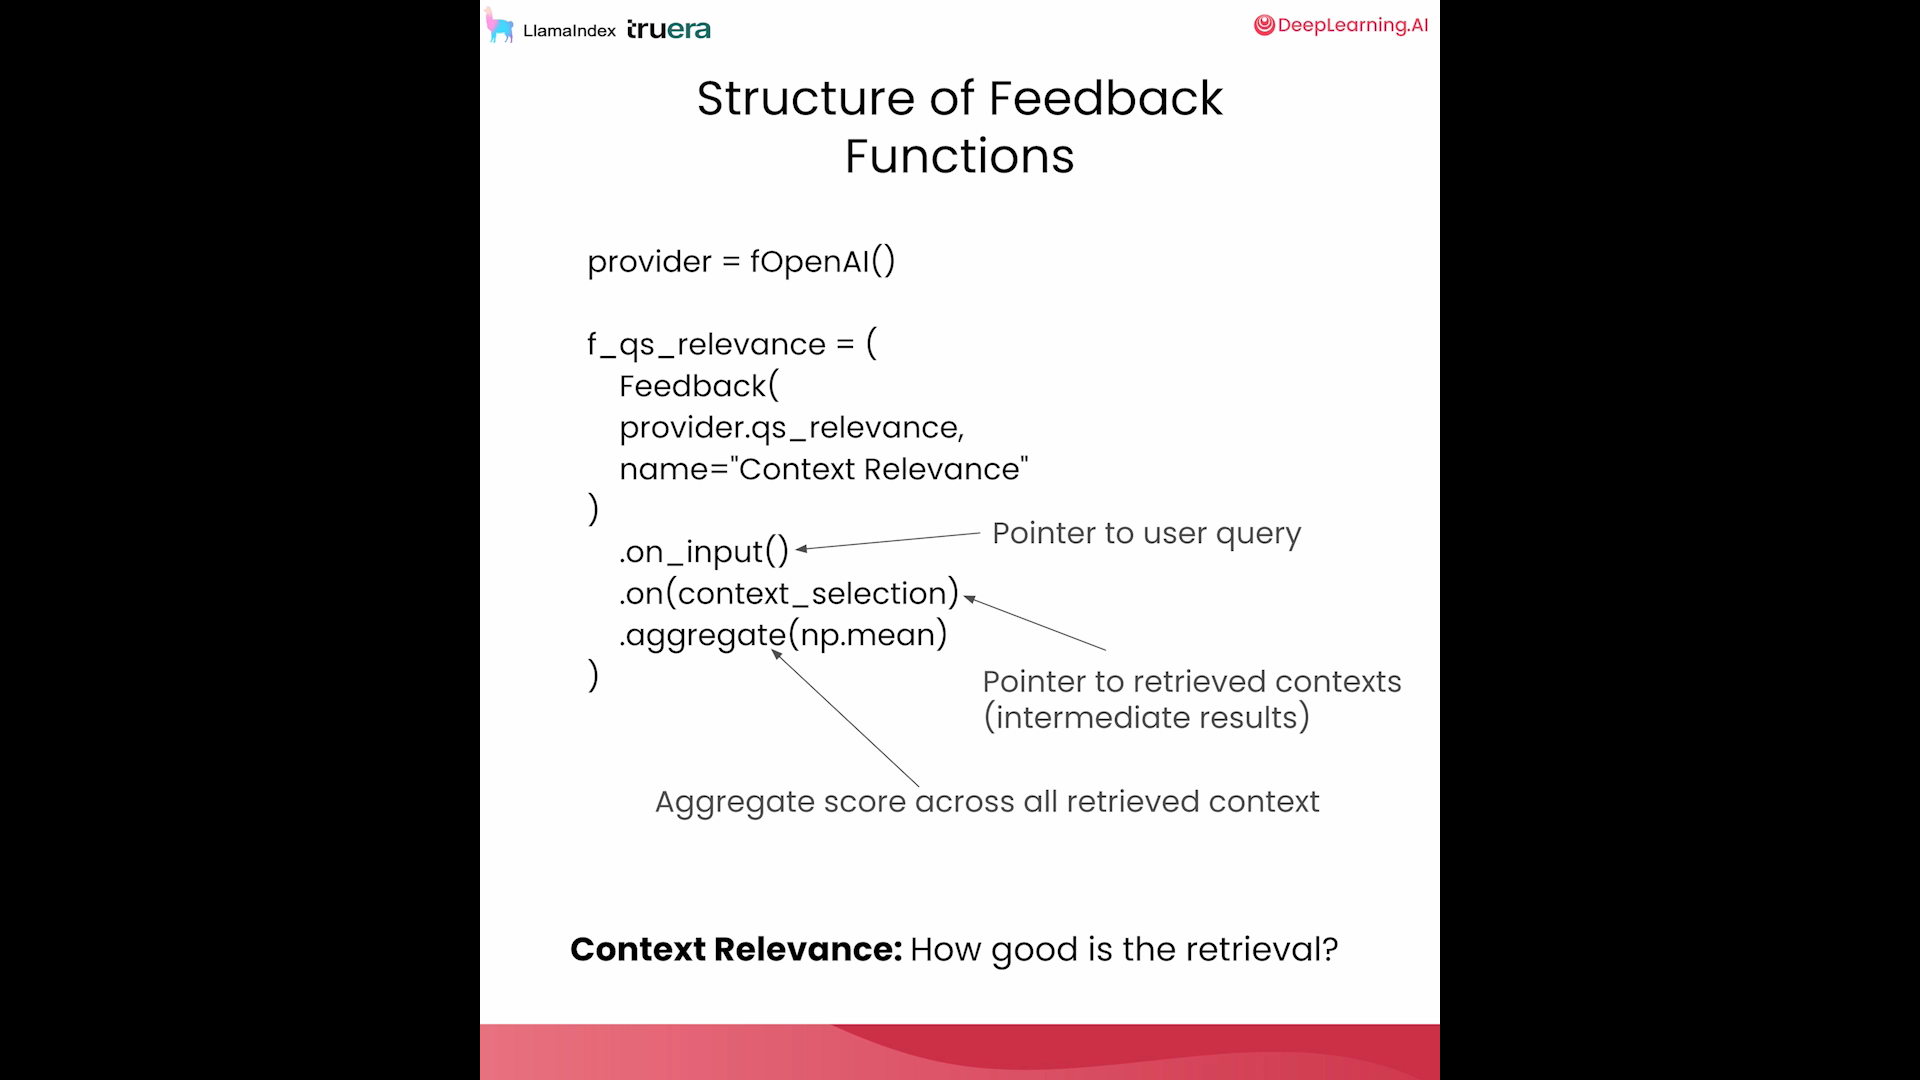

In [43]:
from trulens_eval import TruLlama

context_selection = TruLlama.select_source_nodes().node.text

In [44]:
import numpy as np

f_qs_relevance = (
    Feedback(provider.qs_relevance,
             name="Context Relevance")
    .on_input()
    .on(context_selection)
    .aggregate(np.mean)
)

✅ In Context Relevance, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input statement will be set to __record__.app.query.rets.source_nodes[:].node.text .


COT - Relevance with Contect Relevance

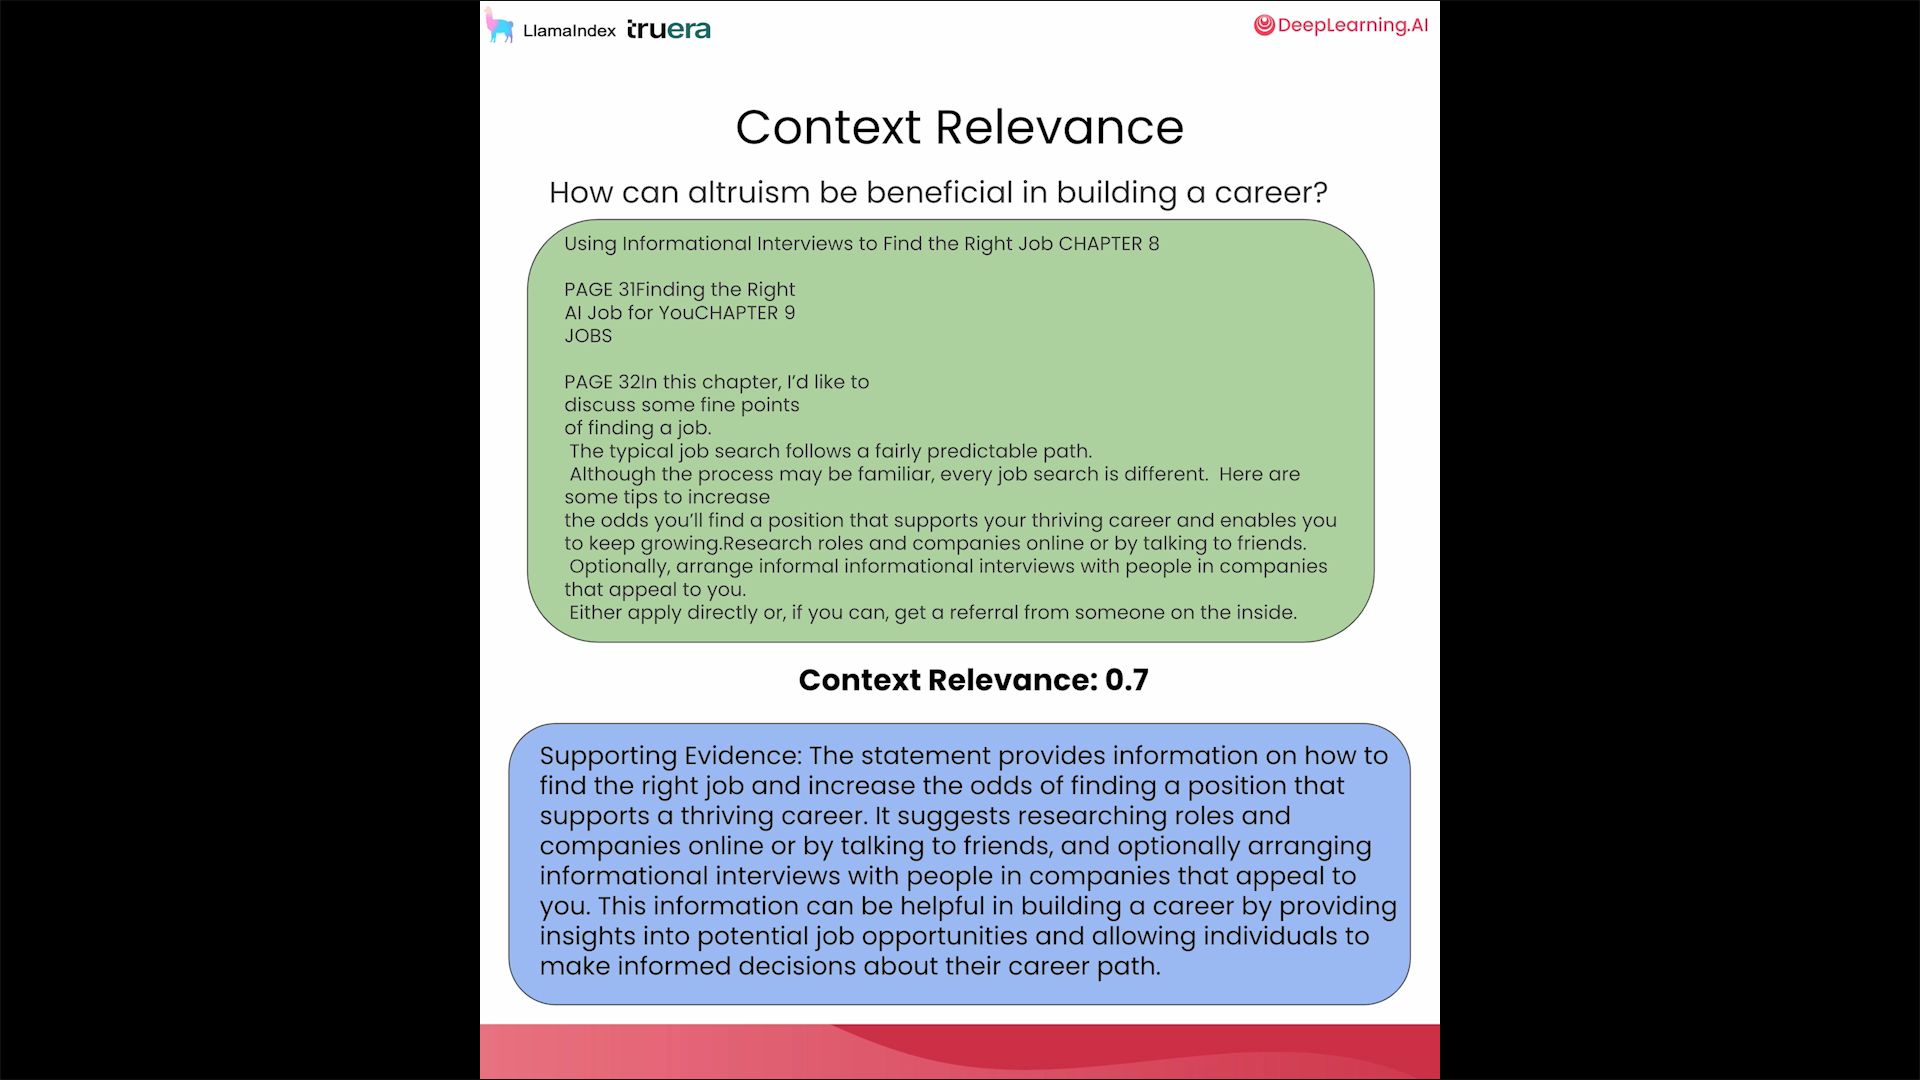

In [45]:
import numpy as np

f_qs_relevance = (
    Feedback(provider.qs_relevance_with_cot_reasons,
             name="Context Relevance")
    .on_input()
    .on(context_selection)
    .aggregate(np.mean)
)

✅ In Context Relevance, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input statement will be set to __record__.app.query.rets.source_nodes[:].node.text .


### 3. Groundedness

In [46]:
from trulens_eval.feedback import Groundedness

grounded = Groundedness(groundedness_provider=provider)

In [47]:
f_groundedness = (
    Feedback(grounded.groundedness_measure_with_cot_reasons,
             name="Groundedness"
            )
    .on(context_selection)
    .on_output()
    .aggregate(grounded.grounded_statements_aggregator)
)

✅ In Groundedness, input source will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .


## Evaluation of the RAG application

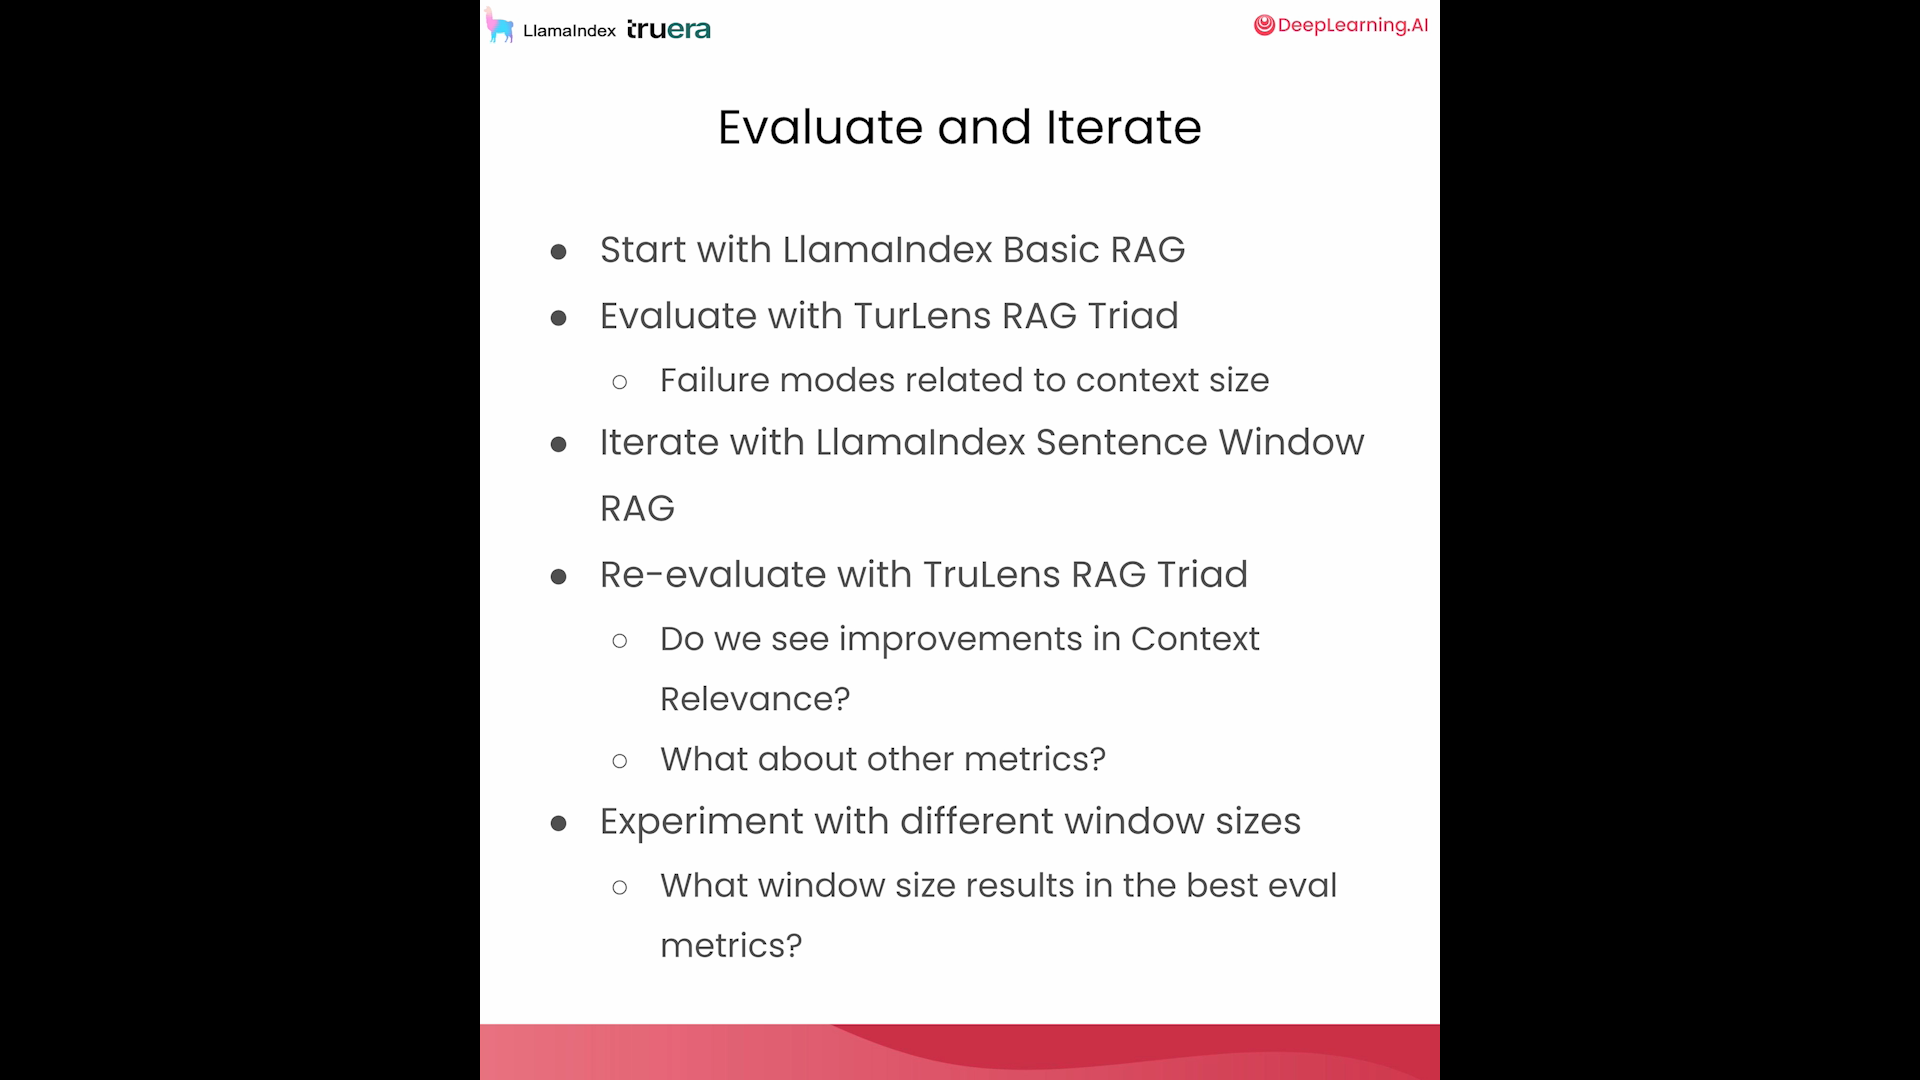

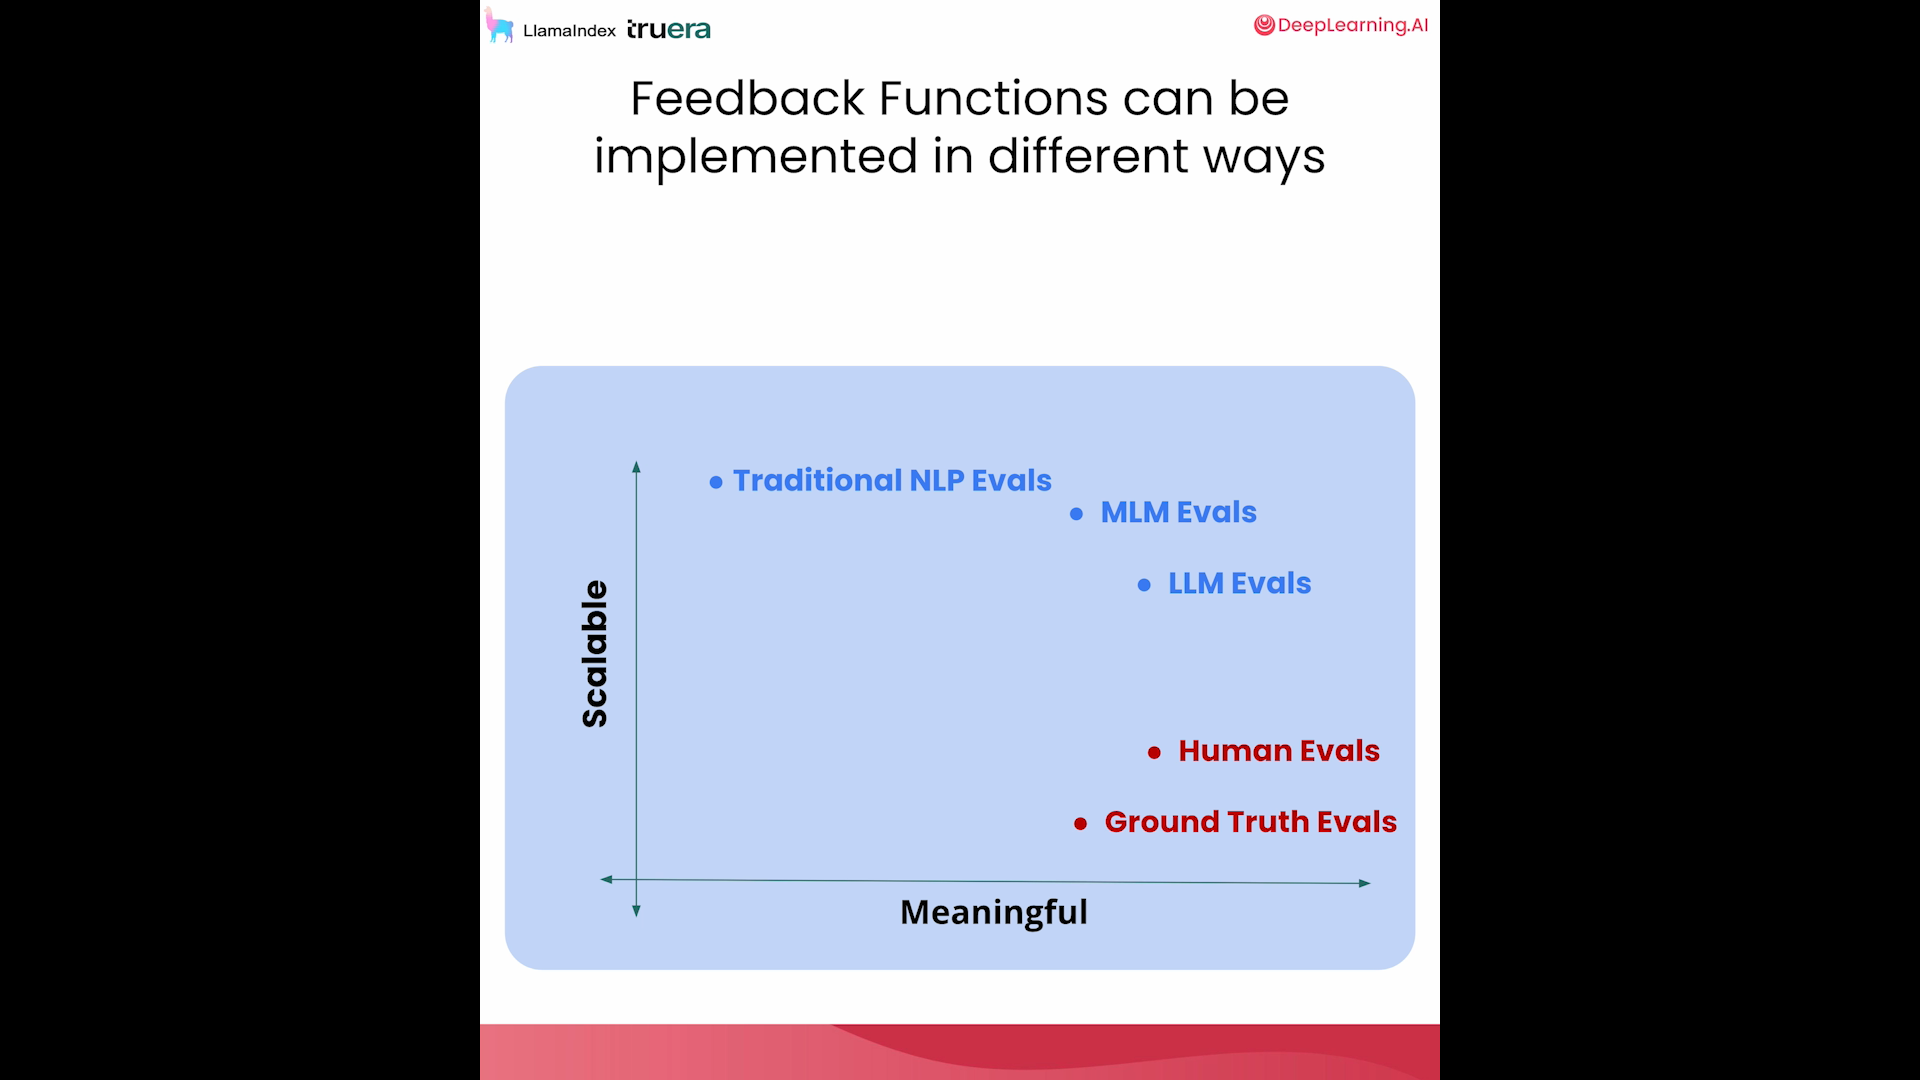

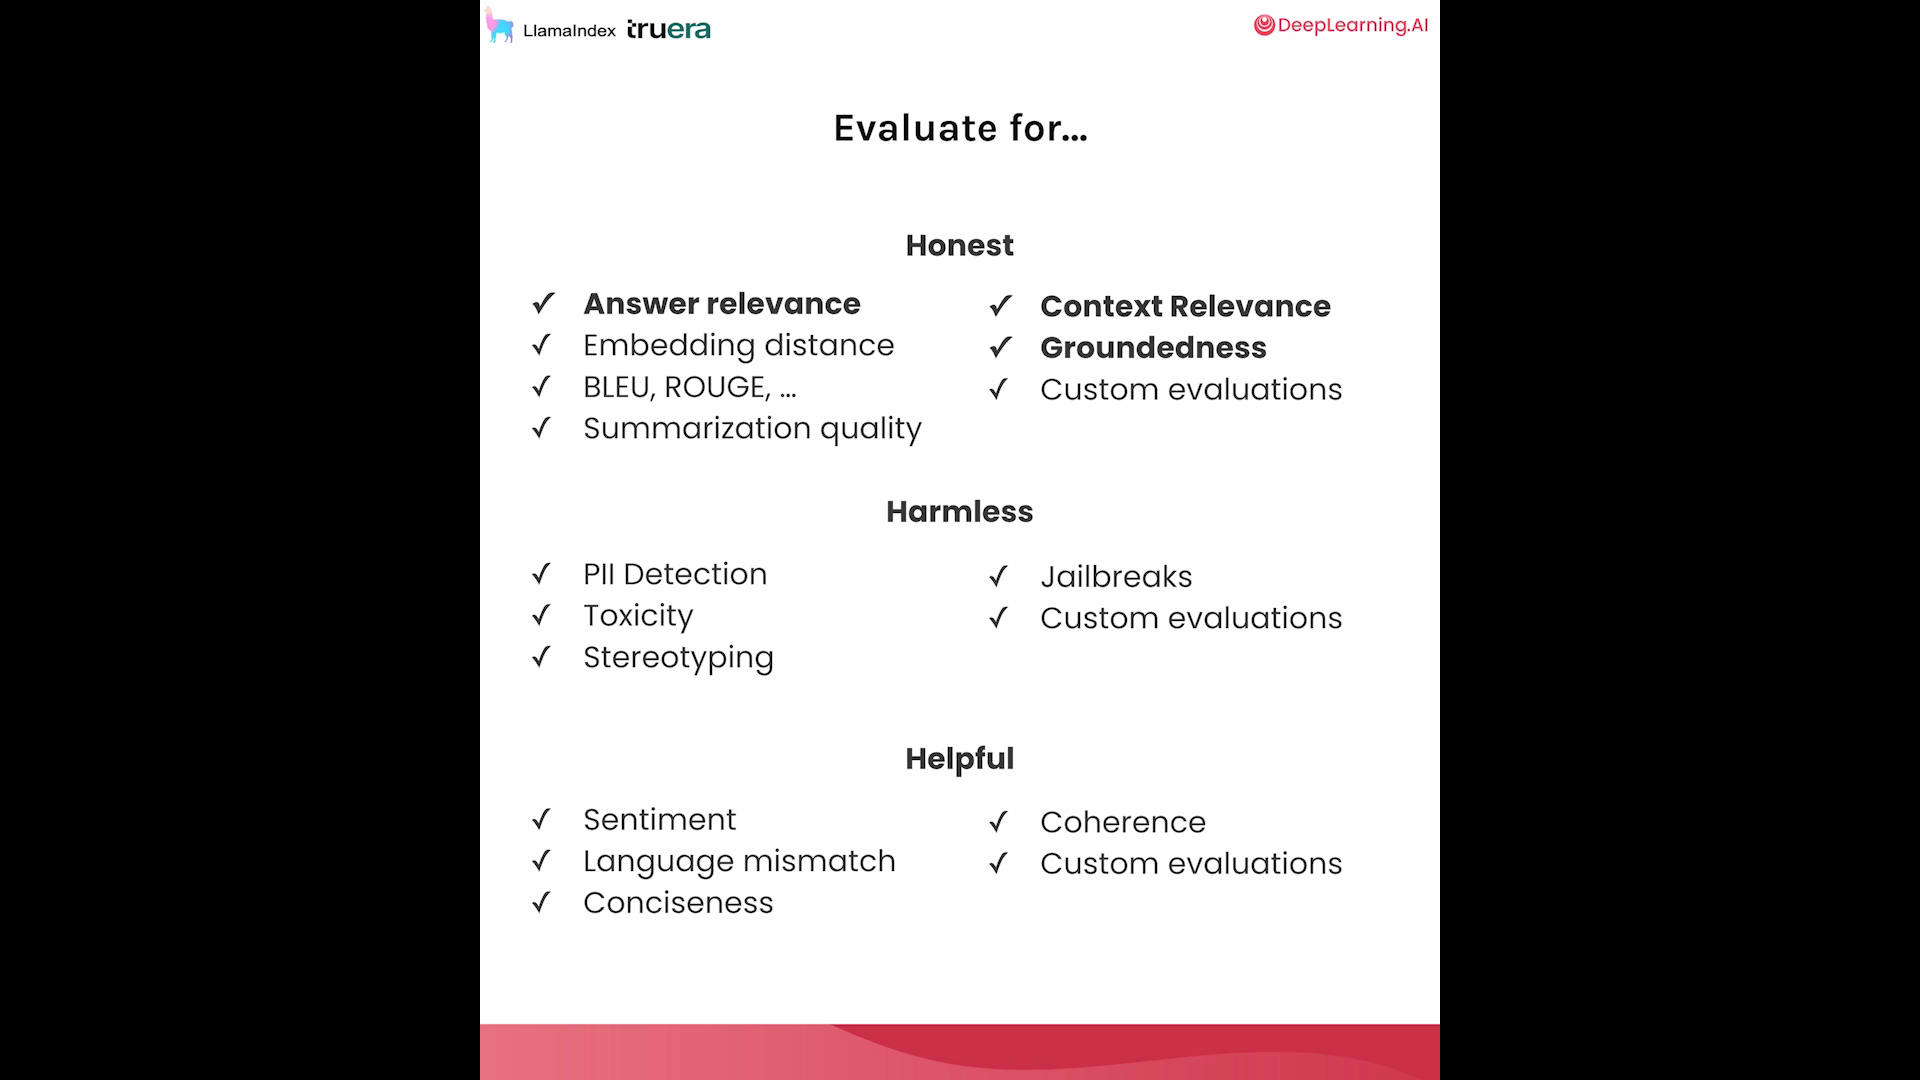

In [48]:
from trulens_eval import TruLlama
from trulens_eval import FeedbackMode

tru_recorder = TruLlama(
    sentence_window_engine,
    app_id="App_1",
    feedbacks=[
        f_qa_relevance,
        f_qs_relevance,
        f_groundedness
    ]
)

In [49]:
eval_questions = []
with open('eval_questions.txt', 'r') as file:
    for line in file:
        # Remove newline character and convert to integer
        item = line.strip()
        eval_questions.append(item)

In [50]:
eval_questions

['What are the keys to building a career in AI?',
 'How can teamwork contribute to success in AI?',
 'What is the importance of networking in AI?',
 'What are some good habits to develop for a successful career?',
 'How can altruism be beneficial in building a career?',
 'What is imposter syndrome and how does it relate to AI?',
 'Who are some accomplished individuals who have experienced imposter syndrome?',
 'What is the first step to becoming good at AI?',
 'What are some common challenges in AI?',
 'Is it normal to find parts of AI challenging?']

In [51]:
eval_questions.append("How can I be successful in AI?")

In [52]:
eval_questions

['What are the keys to building a career in AI?',
 'How can teamwork contribute to success in AI?',
 'What is the importance of networking in AI?',
 'What are some good habits to develop for a successful career?',
 'How can altruism be beneficial in building a career?',
 'What is imposter syndrome and how does it relate to AI?',
 'Who are some accomplished individuals who have experienced imposter syndrome?',
 'What is the first step to becoming good at AI?',
 'What are some common challenges in AI?',
 'Is it normal to find parts of AI challenging?',
 'How can I be successful in AI?']

In [53]:
for question in eval_questions:
    with tru_recorder as recording:
        sentence_window_engine.query(question)

A new object of type <class 'llama_index.query_engine.retriever_query_engine.RetrieverQueryEngine'> at 0x7f97a021ba00 is calling an instrumented method <function BaseQueryEngine.query at 0x7f98df193b50>. The path of this call may be incorrect.
Guessing path of new object is app based on other object (0x7f97a2876320) using this function.
A new object of type <class 'llama_index.query_engine.retriever_query_engine.RetrieverQueryEngine'> at 0x7f97a021ba00 is calling an instrumented method <function RetrieverQueryEngine.retrieve at 0x7f98dd53e9e0>. The path of this call may be incorrect.
Guessing path of new object is app based on other object (0x7f97a2876320) using this function.
A new object of type <class 'llama_index.indices.vector_store.retrievers.retriever.VectorIndexRetriever'> at 0x7f97a021b880 is calling an instrumented method <function BaseRetriever.retrieve at 0x7f98df192ef0>. The path of this call may be incorrect.
Guessing path of new object is app.retriever based on other obj

In [54]:
records, feedback = tru.get_records_and_feedback(app_ids=[])
records.head()

app_id                                           app_json  \
0  App_1  {"app_id": "App_1", "tags": "-", "metadata": {...   
1  App_1  {"app_id": "App_1", "tags": "-", "metadata": {...   
2  App_1  {"app_id": "App_1", "tags": "-", "metadata": {...   
3  App_1  {"app_id": "App_1", "tags": "-", "metadata": {...   
4  App_1  {"app_id": "App_1", "tags": "-", "metadata": {...   

                                                type  \
0  RetrieverQueryEngine(llama_index.query_engine....   
1  RetrieverQueryEngine(llama_index.query_engine....   
2  RetrieverQueryEngine(llama_index.query_engine....   
3  RetrieverQueryEngine(llama_index.query_engine....   
4  RetrieverQueryEngine(llama_index.query_engine....   

                                      record_id  \
0  record_hash_84adfe913d23b33b6359336f42b7dadd   
1  record_hash_606c4e960463548d6988bc9d0860feca   
2  record_hash_07ab70f1e0318937c58908b081b7f2da   
3  record_hash_9e33035a1511fb6d7e5d2bad0331851b   
4  record_hash_4c3231104ee681b12664bbd284b87a5e   

                                               input  \
0    "What are the keys to building a career in AI?"   
1    "How can teamwork contribute to success in AI?"   
2      "What is the importance of networking in AI?"   
3  "What are some good habits to develop for a su...   
4  "How can altruism be beneficial in building a ...   

                                              output tags  \
0  "The keys to building a career in AI are learn...    -   
1  "Teamwork can contribute to success in AI by a...    -   
2  "Networking is important in AI because it allo...    -   
3  "Developing good habits in eating, exercise, s...    -   
4  "Altruism can be beneficial in building a care...    -   

                                         record_json  \
0  {"record_id": "record_hash_84adfe913d23b33b635...   
1  {"record_id": "record_hash_606c4e960463548d698...   
2  {"record_id": "record_hash_07ab70f1e0318937c58...   
3  {"record_id": "record_hash_9e33035a1511fb6d7e5...   
4  {"record_id": "record_hash_4c3231104ee681b1266...   

                                           cost_json  \
0  {"n_requests": 1, "n_successful_requests": 1, ...   
1  {"n_requests": 1, "n_successful_requests": 1, ...   
2  {"n_requests": 1, "n_successful_requests": 1, ...   
3  {"n_requests": 1, "n_successful_requests": 1, ...   
4  {"n_requests": 1, "n_successful_requests": 1, ...   

                                           perf_json  \
0  {"start_time": "2023-12-27T02:59:23.958960", "...   
1  {"start_time": "2023-12-27T02:59:31.228777", "...   
2  {"start_time": "2023-12-27T02:59:39.181348", "...   
3  {"start_time": "2023-12-27T02:59:47.334108", "...   
4  {"start_time": "2023-12-27T02:59:53.516922", "...   

                           ts  Answer Relevance  Groundedness  \
0  2023-12-27T02:59:31.017102               1.0          1.00   
1  2023-12-27T02:59:38.979636               1.0          0.95   
2  2023-12-27T02:59:47.138149               1.0          0.65   
3  2023-12-27T02:59:53.318053               1.0          1.00   
4  2023-12-27T02:59:59.807847               1.0          0.50   

   Context Relevance                             Answer Relevance_calls  \
0               0.40  [{'args': {'prompt': 'What are the keys to bui...   
1               0.75  [{'args': {'prompt': 'How can teamwork contrib...   
2               0.00  [{'args': {'prompt': 'What is the importance o...   
3               0.30  [{'args': {'prompt': 'What are some good habit...   
4               0.35  [{'args': {'prompt': 'How can altruism be bene...   

                                  Groundedness_calls  \
0  [{'args': {'source': 'Chapter 7: A Simple Fram...   
1  [{'args': {'source': 'To get 
a project starte...   
2  [{'args': {'source': 'What is the hiring proce...   
3  [{'args': {'source': '(For example, many 
arti...   
4  [{'args': {'source': 'Many successful people d...   

                             Context Relevance_calls  latency  total_tokens  \
0  [{'

In [55]:
import pandas as pd

pd.set_option("display.max_colwidth", None)
records[["input", "output"] + feedback]

input  \
0                                   "What are the keys to building a career in AI?"   
1                                   "How can teamwork contribute to success in AI?"   
2                                     "What is the importance of networking in AI?"   
3                   "What are some good habits to develop for a successful career?"   
4                            "How can altruism be beneficial in building a career?"   
5                         "What is imposter syndrome and how does it relate to AI?"   
6   "Who are some accomplished individuals who have experienced imposter syndrome?"   
7                                  "What is the first step to becoming good at AI?"   
8                                          "What are some common challenges in AI?"   
9                                   "Is it normal to find parts of AI challenging?"   
10                                                 "How can I be successful in AI?"   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           output  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               "The keys to building a career in AI are learning foundational technical skills, working on projects, and finding a job, all of which is supported by being part of a community."   
1                                                                                                                                            "Teamwork can contribute to success in AI by allowing individuals to leverage the expertise and insights of their colleagues. When working on larger AI projects that require collaboration, the ability to lead and work effectively as a team becomes crucial. By working together, team members can share their deep technical insights, make informed decisions about technical architecture or data collection, and ultimately improve the project. Additionally, being surrounded by colleagues who are dedicated, hardworking, and continuously learning can inspire individuals to do the same, leading to greater success in AI endeavors."   
2                                                                                                                                             "Networking is important in AI because it allows individuals to connect with others who have experience and knowledge in the field. By reaching out to people in their network, such as friends or alumni, individuals can receive guidance and support as they navigate their AI career. Additionally, attending meetups and engaging in informational interviews can help individuals expand their network and gain insights from professionals in positions that align with their interests. This networking can be valuable in the AI field, which is constantly evolving and where job 

In [56]:
tru.get_leaderboard(app_ids=[])

Groundedness  Answer Relevance  Context Relevance   latency  \
app_id                                                                
App_1       0.890909          0.990909           0.459091  6.272727   

        total_cost  
app_id              
App_1     0.000883

In [57]:
tru.run_dashboard()

Starting dashboard ...
Config file already exists. Skipping writing process.
Credentials file already exists. Skipping writing process.


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at https://s172-31-7-241p16183.lab-aws-production.deeplearning.ai/ .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

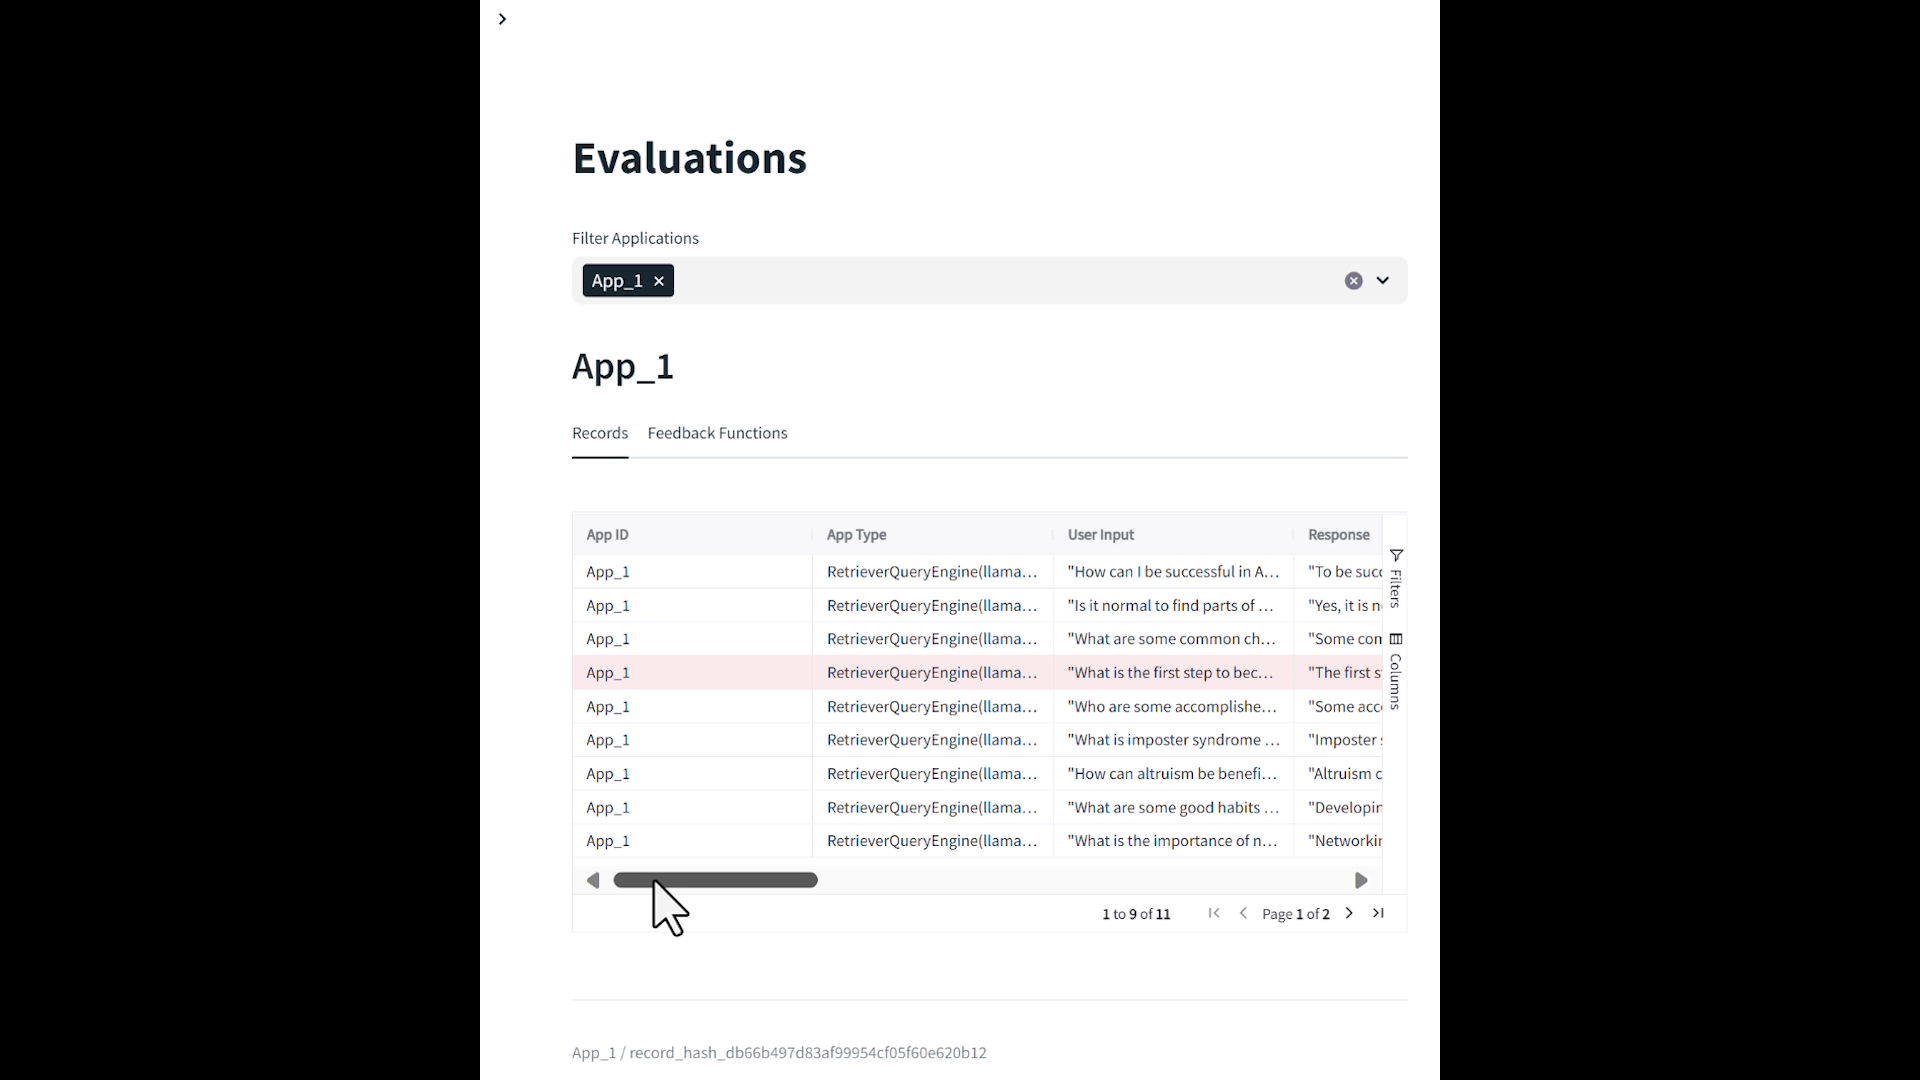

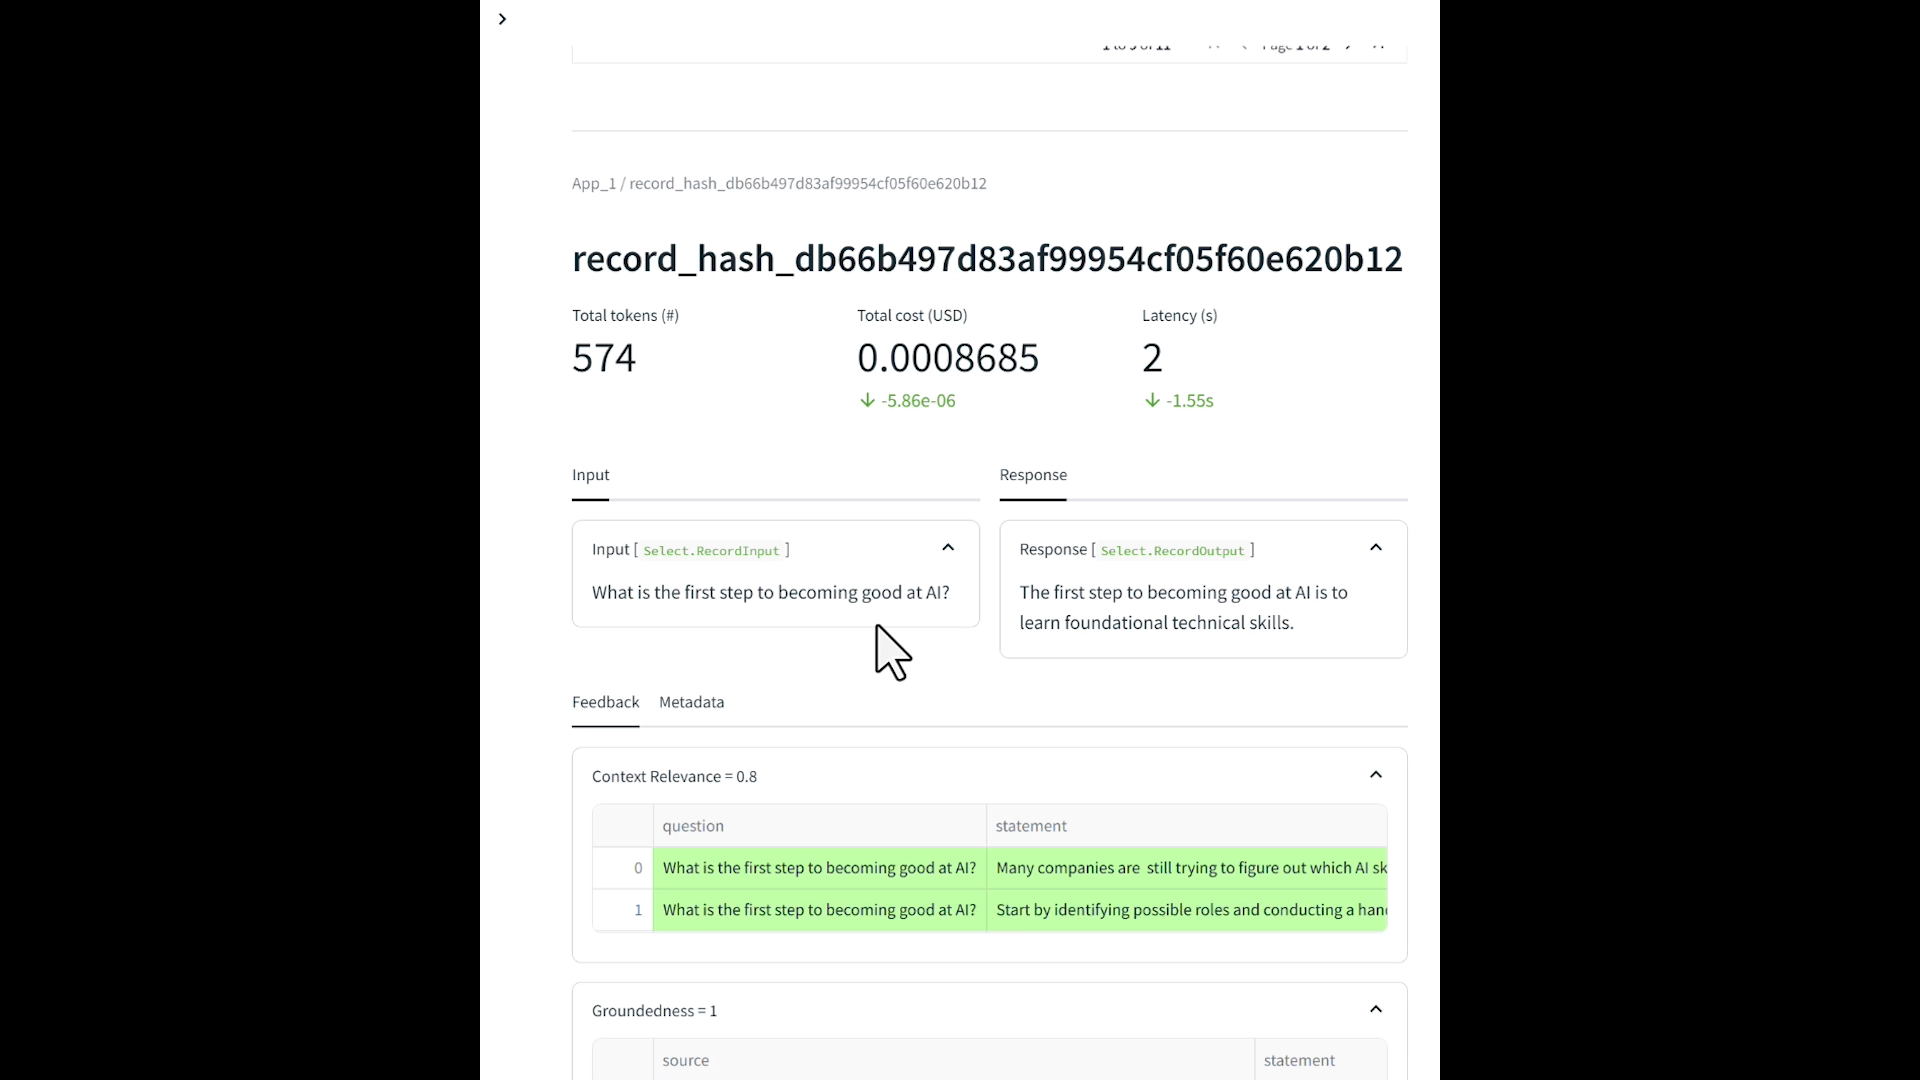

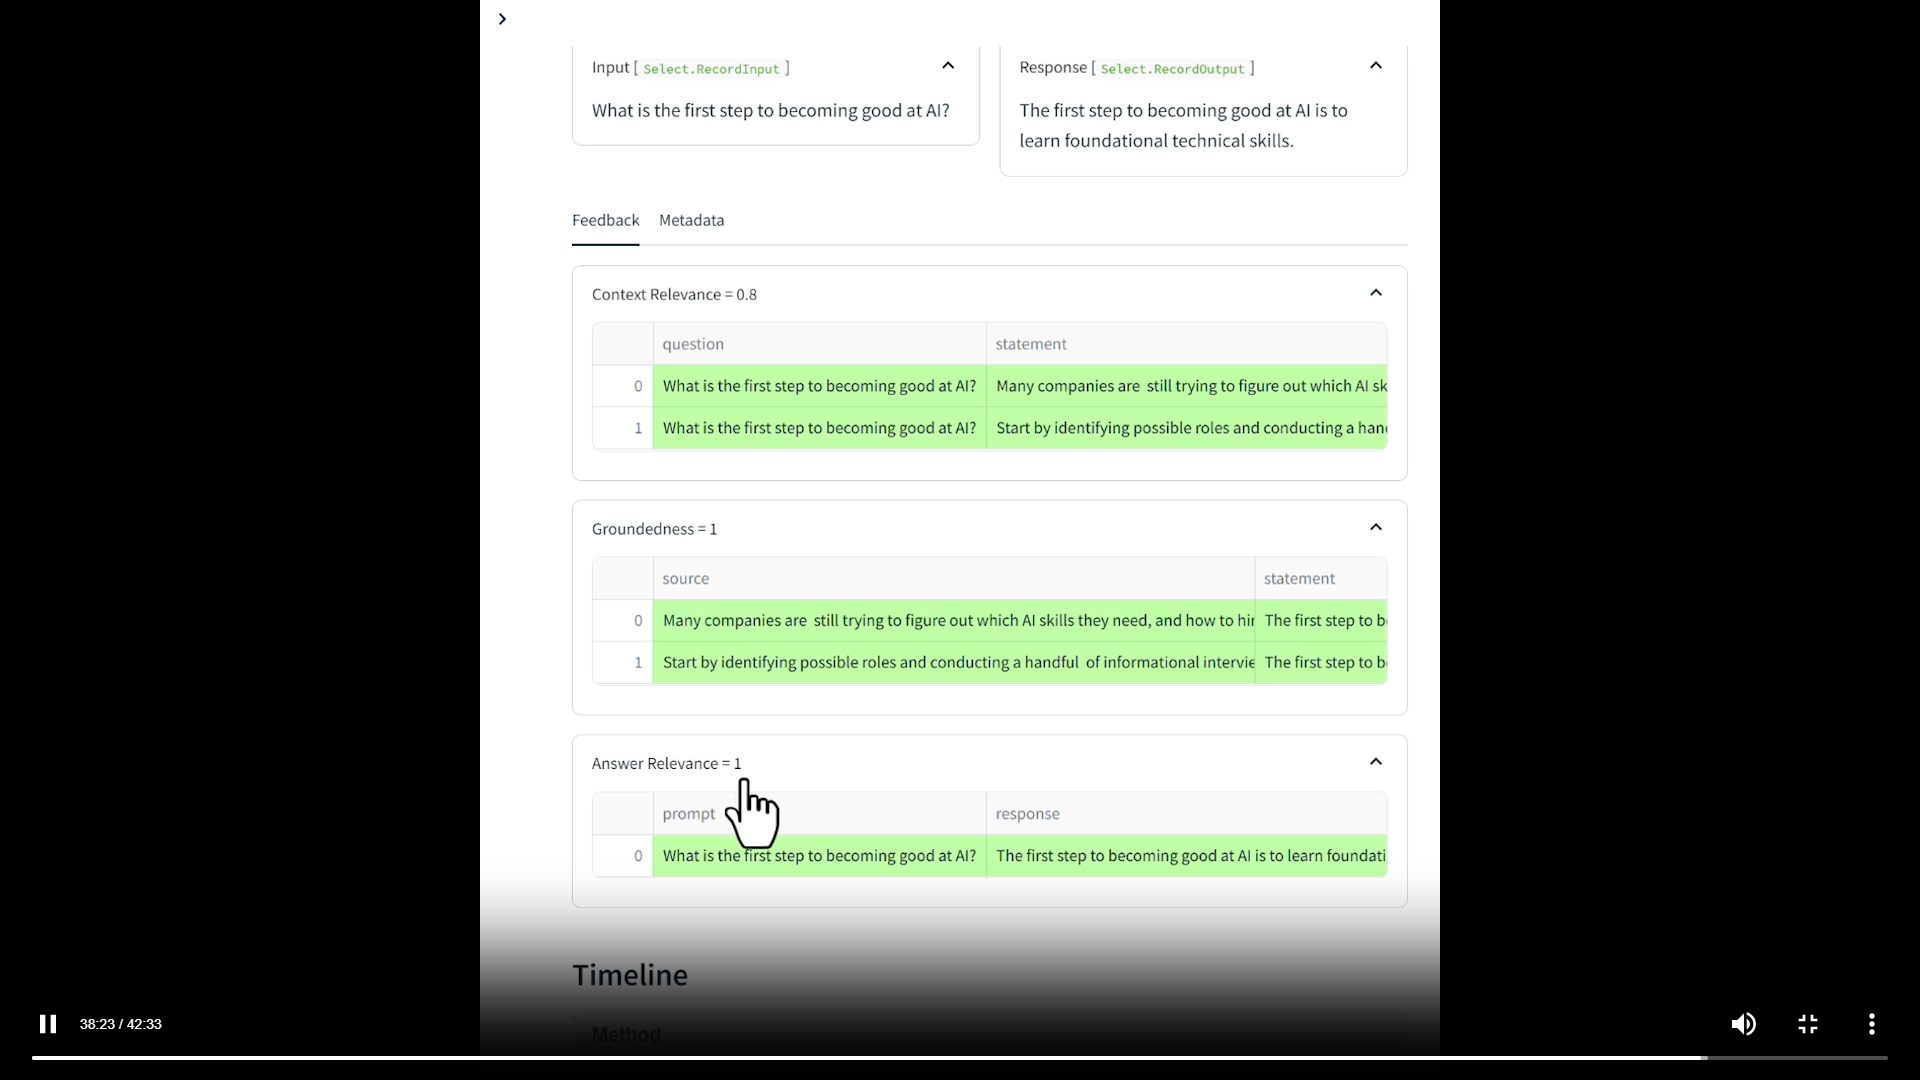

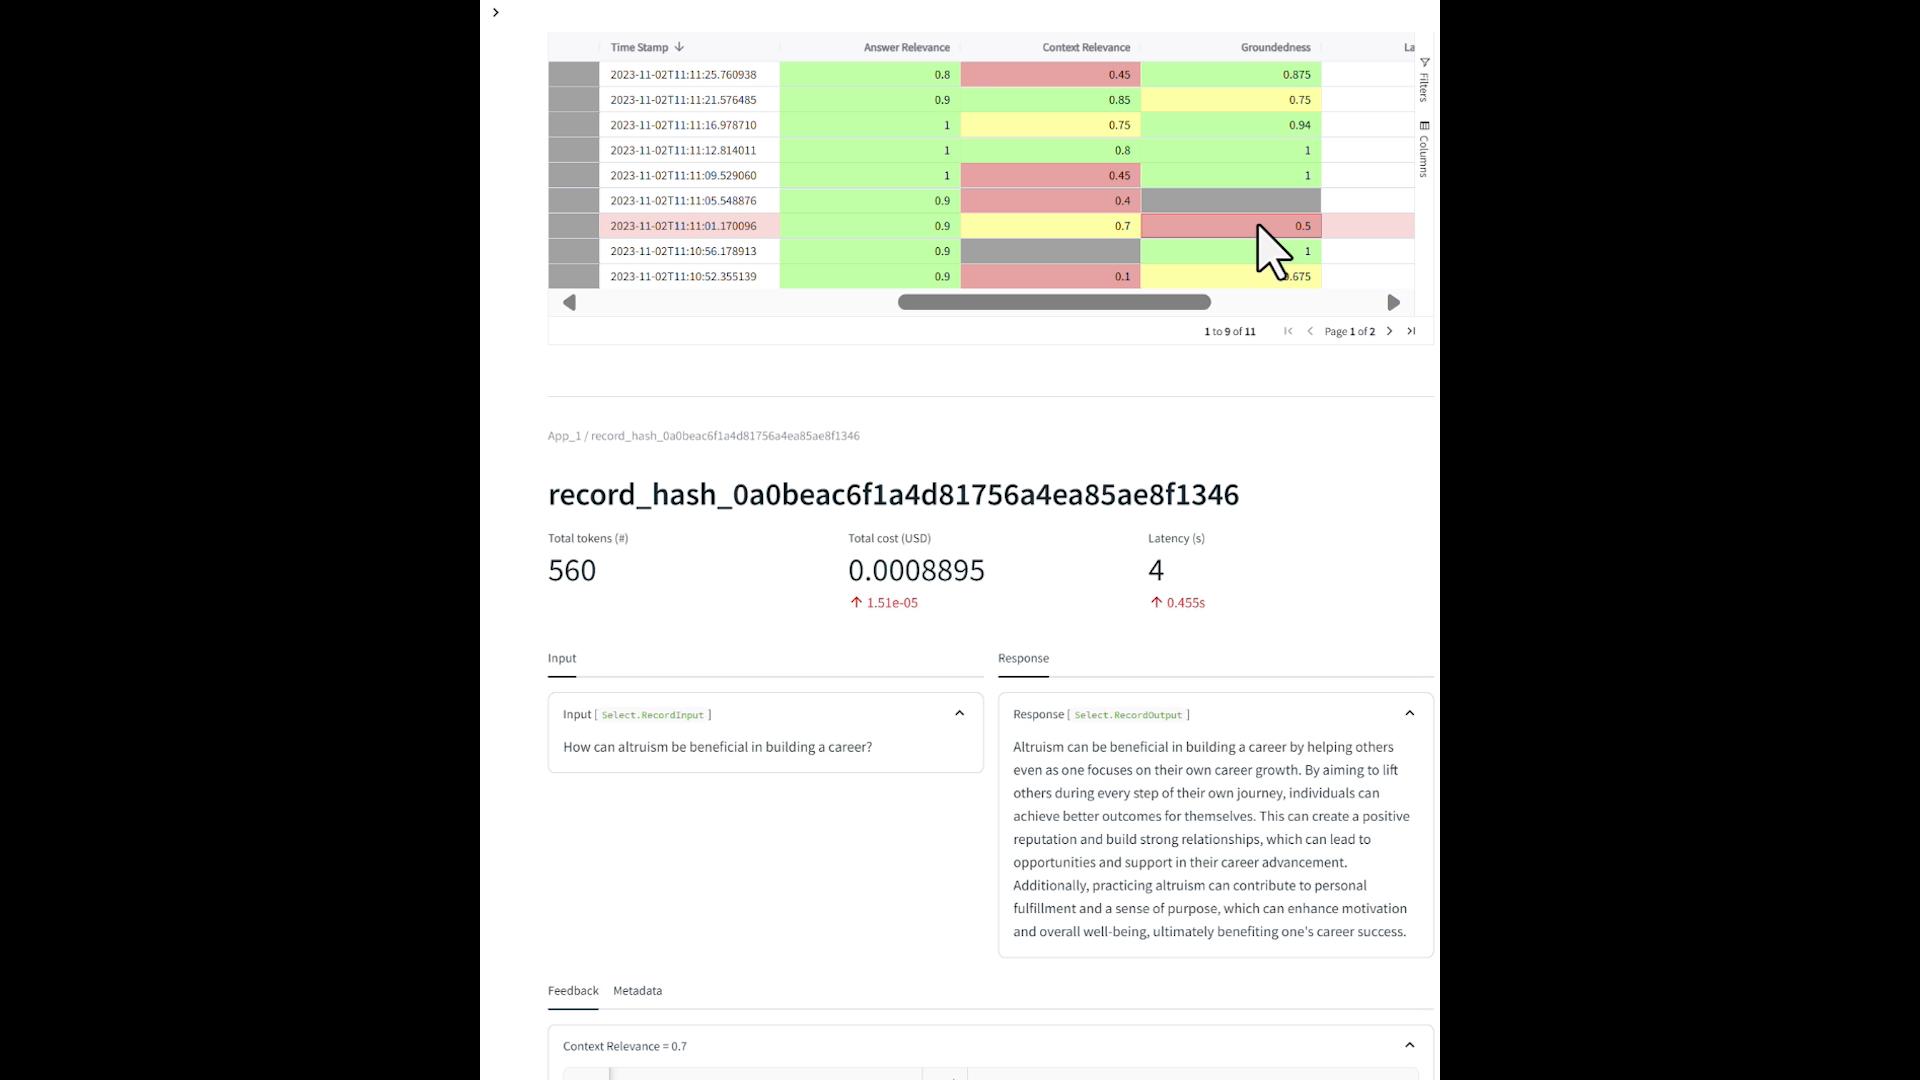

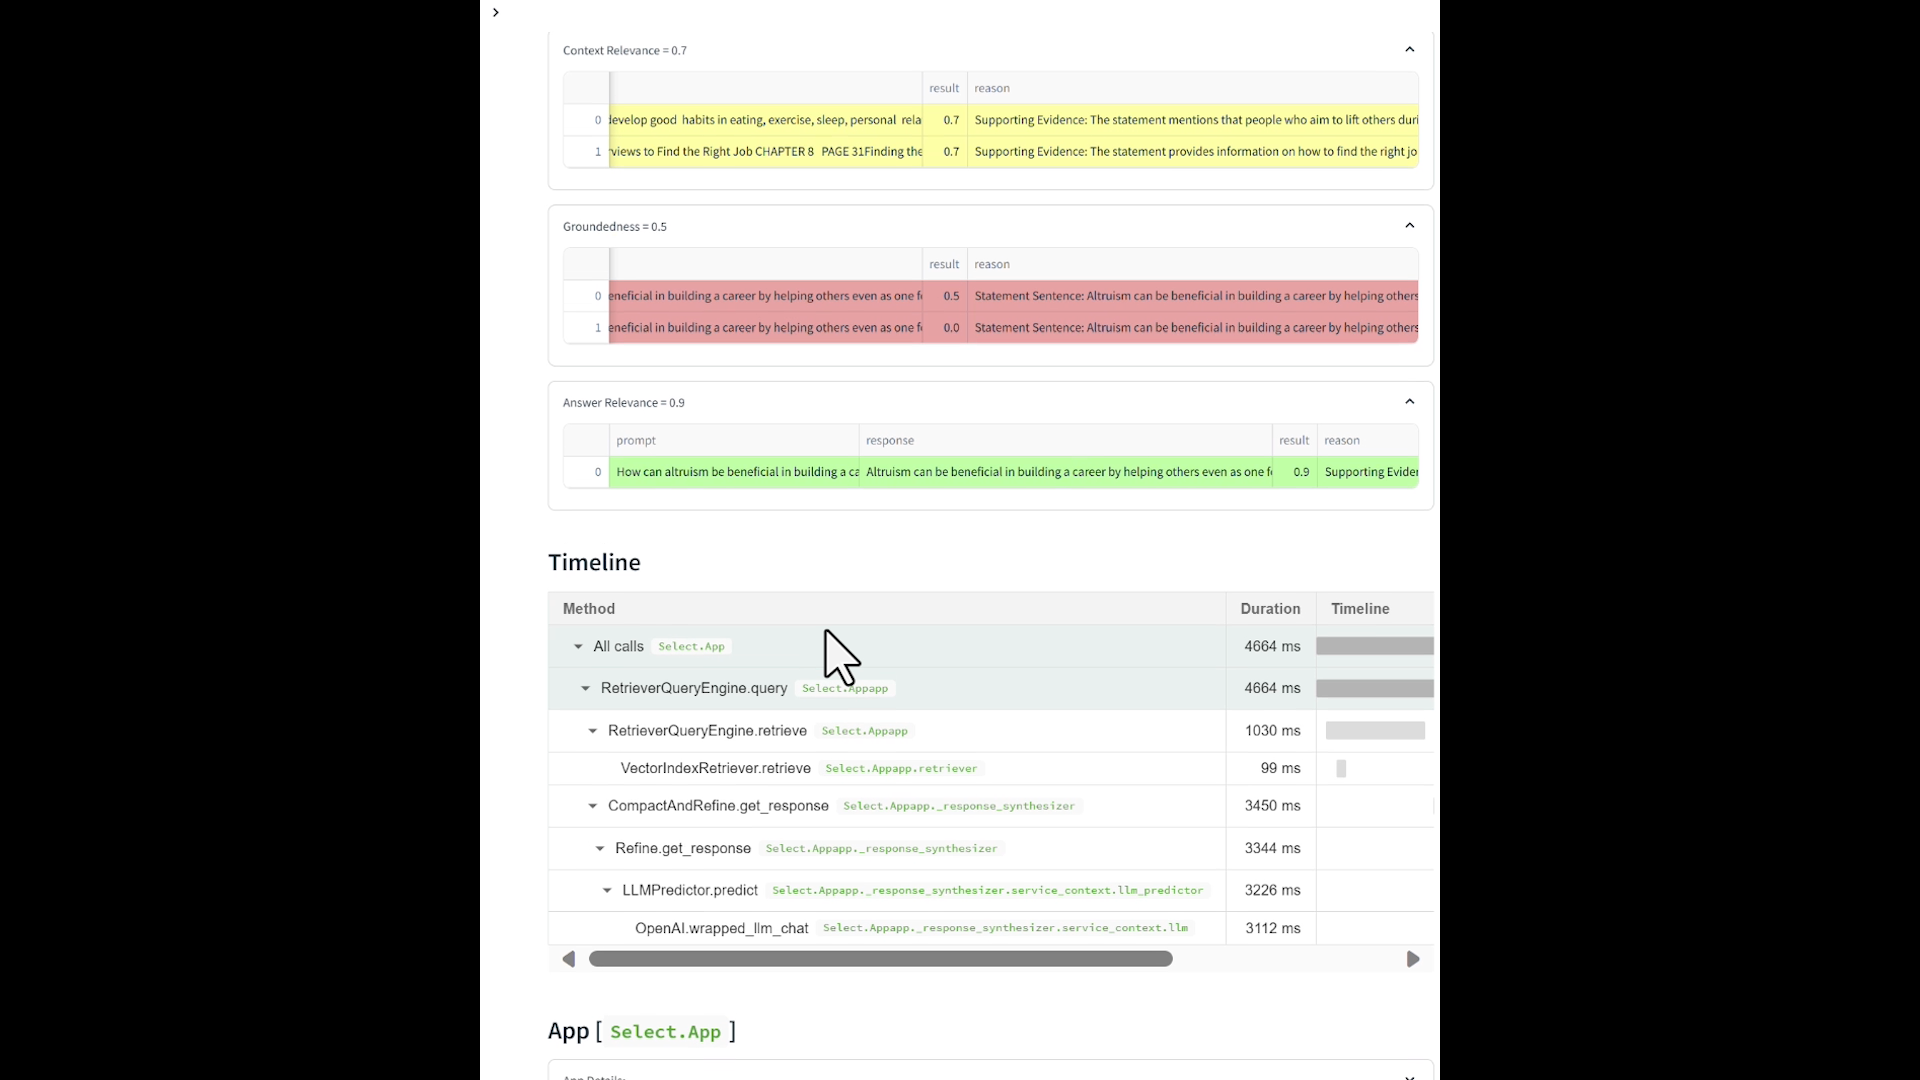

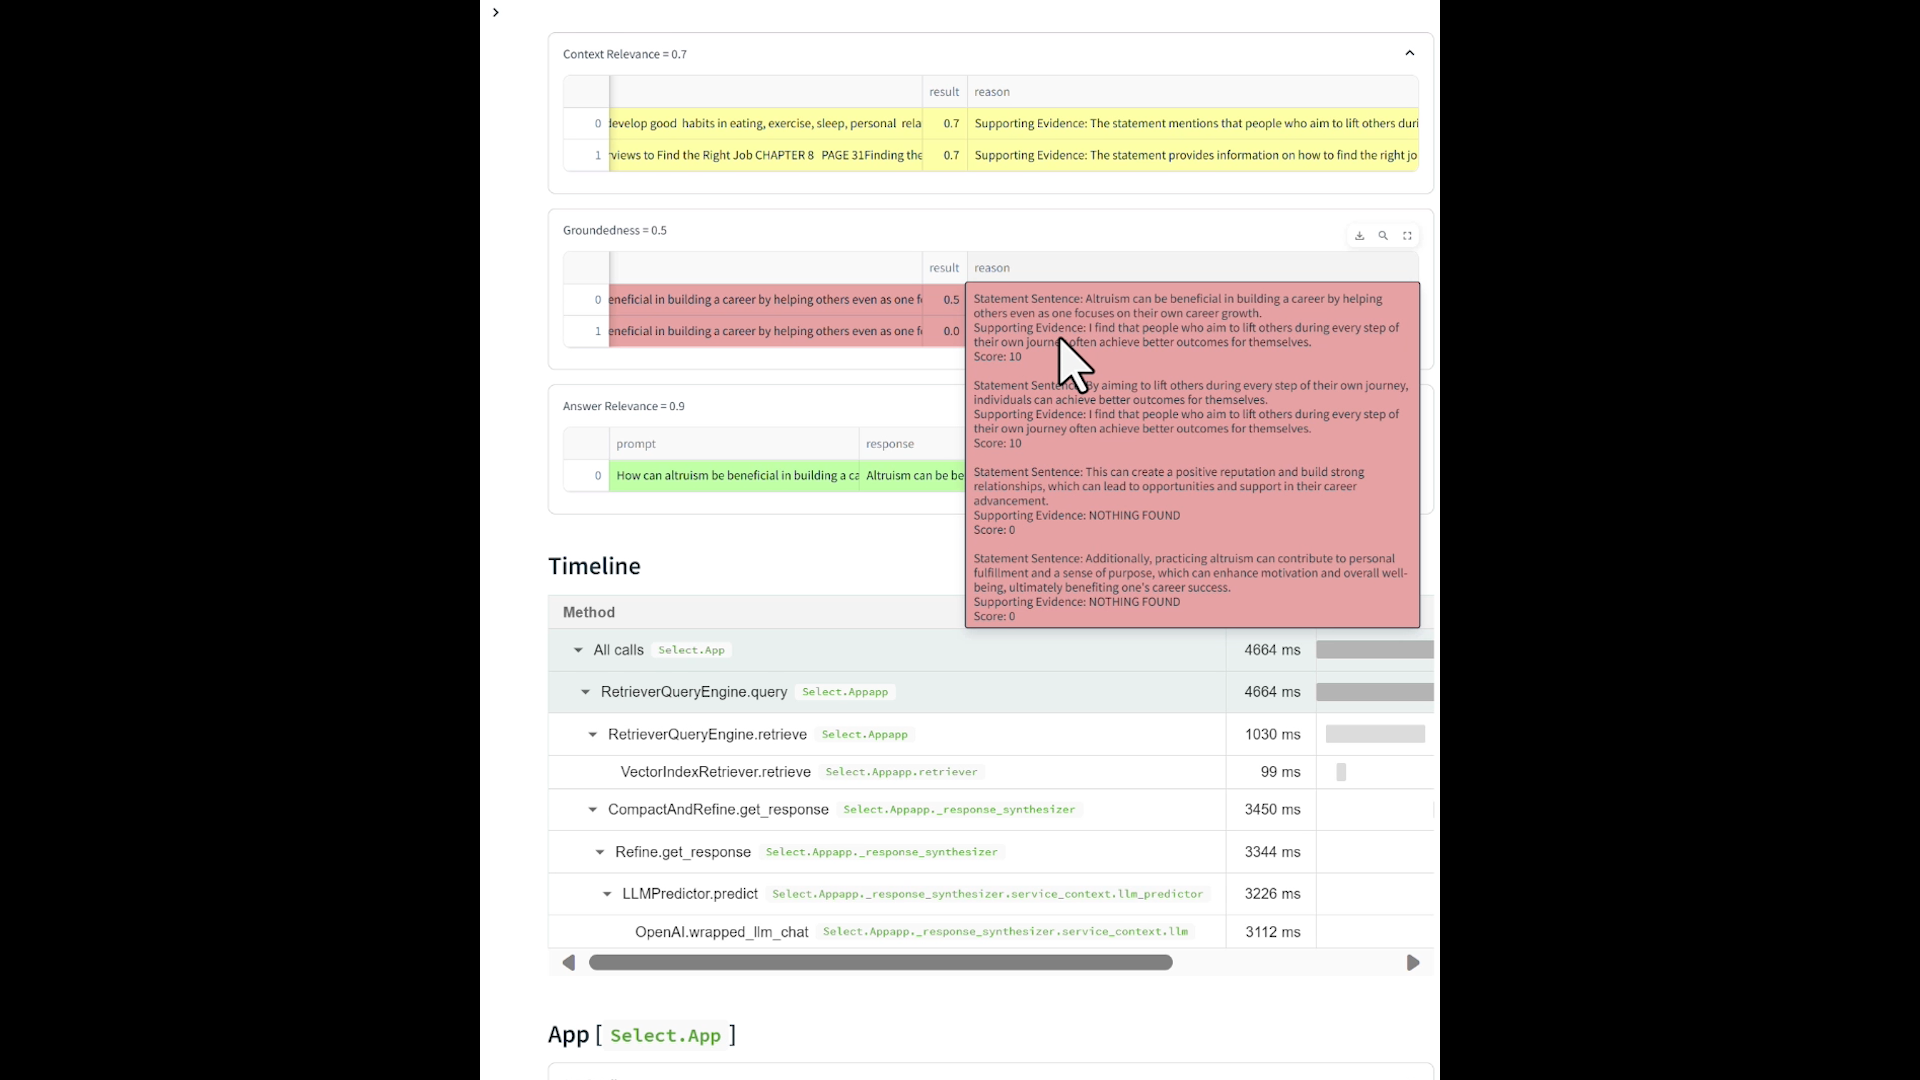